In [1]:
# AeroCNN-II with U-Net
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5897547805430143443
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22603104256
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 680297098673786422
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 22409904128
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9978920952111700371
 physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6"
 xla_global_id: 2144165316,
 name: "/device:GPU:2"
 device_type: "GPU"
 memory_limit: 22603104256
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17774648971253733530
 physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6"
 xla_global_i

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy(["/GPU:0","/GPU:1", "/GPU:2"], cross_device_ops = tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


In [4]:
n_kernel=50
l2Regularizer=1e-09
kernel_size1 = 5
kernel_size2 = 5
#kernel_size3 = 5
n_grid = 101
strides = 1
input_size = 100

In [5]:
alpha = np.linspace(-10,10,11).reshape((-1,1))

In [6]:
aa = np.zeros((11*133,1))
for i in range(0, 133):
    aa[11*i:11*(i+1), :] = alpha[:,:]

In [7]:
aa = aa.reshape((133, 11, 1, 1))

In [8]:
os.chdir('D:\\AeroCNN2Inputs')

In [9]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [10]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [11]:
image_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        csv_file_name = origin + '\\airfoil' + str(i) + "_alpha"+ str(int(alpha[j])) + ".csv"
        data = pd.read_csv(csv_file_name, header=None)
        image_df = pd.concat([image_df, data], axis=0)

In [12]:
image_np = image_df.iloc[:, :].values

In [13]:
image = image_np.reshape((133, 11, 100, 100))

In [14]:
image = 1-image/100

In [15]:
path = 'D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values

In [17]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha"+ str(int(alpha[1])) + "_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [18]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    for j in range(0, alpha.shape[0]):
        data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha"+ str(int(alpha[j])) + "_interpolated.csv"
        data = pd.read_csv(data_name, header=None)
        Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [19]:
geometry_orig = airfoilName_df.iloc[:, 1].values

In [20]:
y_imp = Vmag_df.iloc[:, :].values

In [21]:
y = y_imp.reshape((133, 11, n_grid, n_grid))

In [22]:
geometry = np.zeros((133*11,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,11):
        geometry[11*index_[0]+j,:] = np.asarray(i)

In [23]:
geometry.shape

(1463, 1)

In [24]:
geometry = geometry.reshape((133, 11, 1))

In [25]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(image, aa, geometry, y, test_size=0.05, random_state=1)

In [26]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [27]:
os.chdir('D:\\TrainedModels\\20221012')

In [29]:
sd = tf.keras.models.load_model('AeroCNN-II_with_U-net_FlowFieldPrediction_50kernel_2by2MaxPooling_1CNNlayer_testSize0.05.h5')

In [30]:
with mirrored_strategy.scope():
    test_results = sd.evaluate(x_train)
    decoded_train = sd.predict(x_train)
    decoded_test = sd.predict(x_test)

3/3 [==============================] - 0s 94ms/step


In [31]:
test_results2 = sd.evaluate(x_test)

3/3 [==============================] - 0s 3ms/step - loss: 5.9397e-05 - rmse: 0.0000e+00


In [32]:
y_train.shape

(1386, 101, 101)

In [33]:
y_train.shape[0]

1386

In [34]:
type(decoded_train.shape[3])

int

In [35]:
type(decoded_train)

numpy.ndarray

In [36]:
type(n_grid)

int

In [37]:
decoded_train = decoded_train.reshape((int(y_train.shape[0]),int(n_grid),int(n_grid)))
decoded_test = decoded_test.reshape((int(y_test.shape[0]),int(n_grid),int(n_grid)))

In [38]:
decoded_train.shape

(1386, 101, 101)

In [39]:
y_train.shape[0]

1386

In [40]:
error_train_abs = np.abs(decoded_train - y_train)

In [41]:
error_test_abs = np.abs(decoded_test - y_test)

In [42]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [43]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [44]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [45]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [46]:
decoded_train.shape

(1386, 101, 101)

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.015859445479225166


In [48]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.019717040438486245


In [49]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.01678113161661169, 0.016910250500104935, 0.016113202792403924, 0.01513667044317006, 0.013520100183333024, 0.012573696643350995, 0.0129484146685033, 0.013578477649494687, 0.013951584321294022, 0.018336214838282874, 0.02950819865016057, 0.02736552999347804, 0.014834018773407242, 0.014529503736436765, 0.013965859812357146, 0.013440339343221993, 0.014249902305725707, 0.013520258402501031, 0.014258327143318227, 0.012522686014539012, 0.014487601748925464, 0.027100622632540084, 0.018917720212468663, 0.028234299657437133, 0.017672205847045475, 0.017015313135955577, 0.015458391585332345, 0.01380891303435156, 0.014876291772260497, 0.01843451798918244, 0.015384030957367033, 0.01487761287993103, 0.017096239844063426, 0.015188715567137393, 0.01665405973667357, 0.017210876217407047, 0.0165632991881191, 0.015207619102972447, 0.01311503488116229, 0.013085008961340128, 0.012946921997218894, 0.014808621564269901, 0.01332012311357349, 0.01633163813307888, 0.04870342655627733, 0.016817530170380866, 0.0

In [50]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.01390852199120363, 0.014235019030184917, 0.014565321279993501, 0.01292211232510457, 0.012964718530983325, 0.011304757982815236, 0.010285272814783536, 0.012161768205962254, 0.011975500030921534, 0.013658837313152209, 0.04095872026460015, 0.020300116483616768, 0.02013382571345481, 0.01921570204278438, 0.019246508742982695, 0.02187300966887659, 0.020666438394460182, 0.02021784437631668, 0.019008451269057397, 0.01885117596715178, 0.019112117908146733, 0.016980667231345118, 0.013062326498927496, 0.014677694423600618, 0.012544268390923126, 0.013294979131676748, 0.013685254179057563, 0.013156887590547972, 0.015690996161457103, 0.01486109688910075, 0.015047557058798854, 0.014584171316491678, 0.045599553814196184, 0.02588356028817041, 0.019872961712154715, 0.012610373980779117, 0.014791240383504389, 0.013167097132710184, 0.013112289487005355, 0.013154295489396813, 0.013178303474992001, 0.015838881577983573, 0.01909825346437911, 0.027683233961489744, 0.027634167646090023, 0.0214960633637223, 

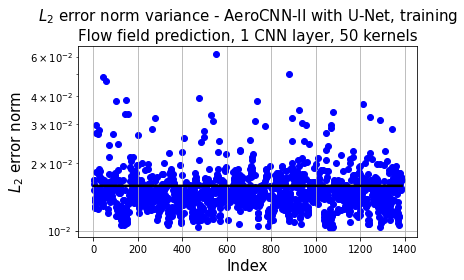

In [51]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, training\nFlow field prediction, 1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

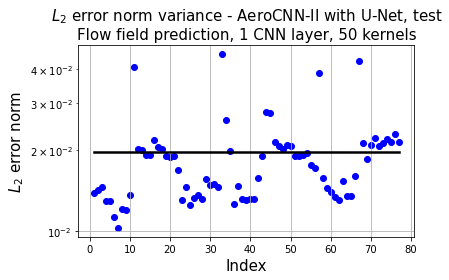

In [52]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - AeroCNN-II with U-Net, test\nFlow field prediction, 1 CNN layer, 50 kernels', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

In [53]:
os.chdir("D:\\AeroCNNII_Images\\20221019\\reference")

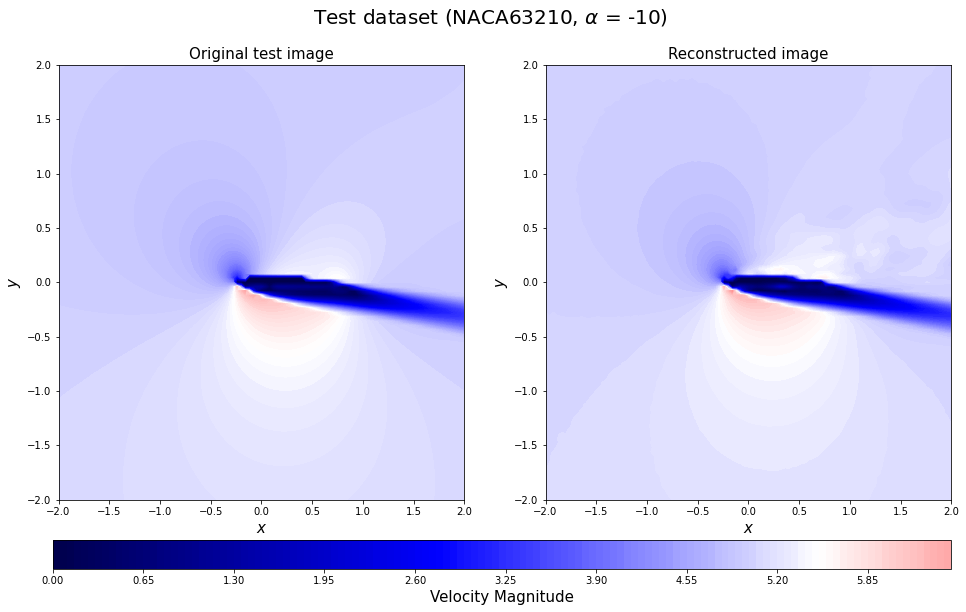

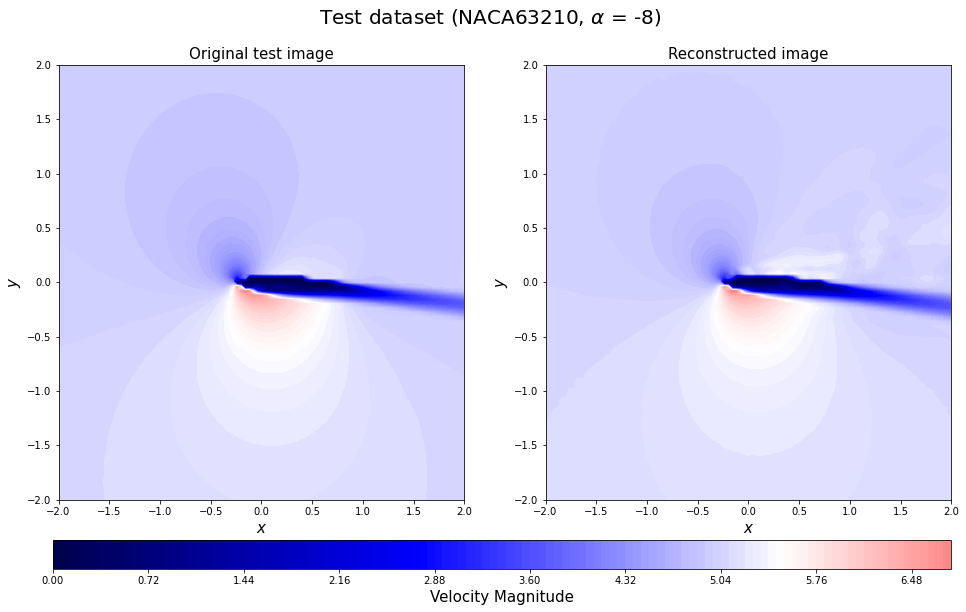

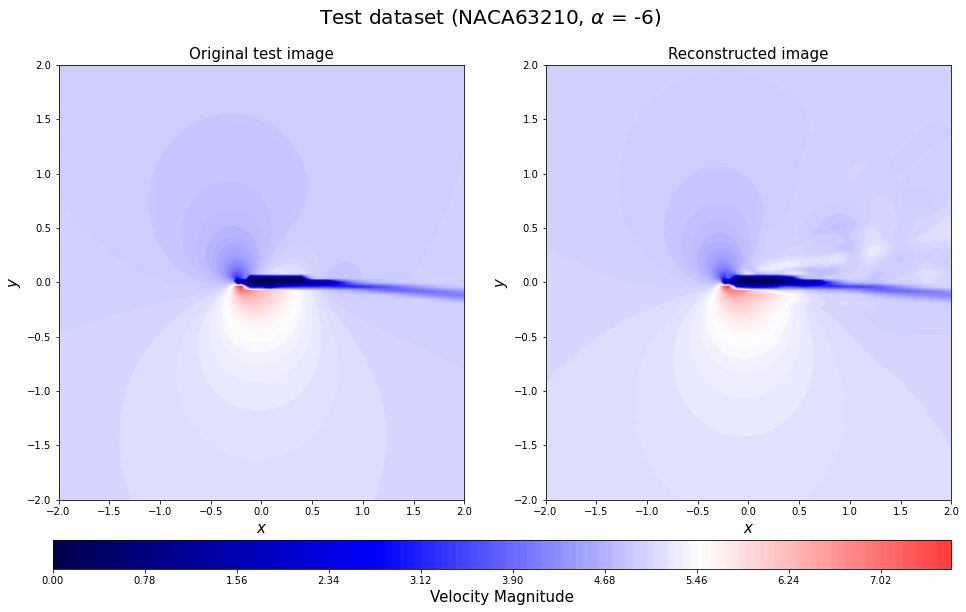

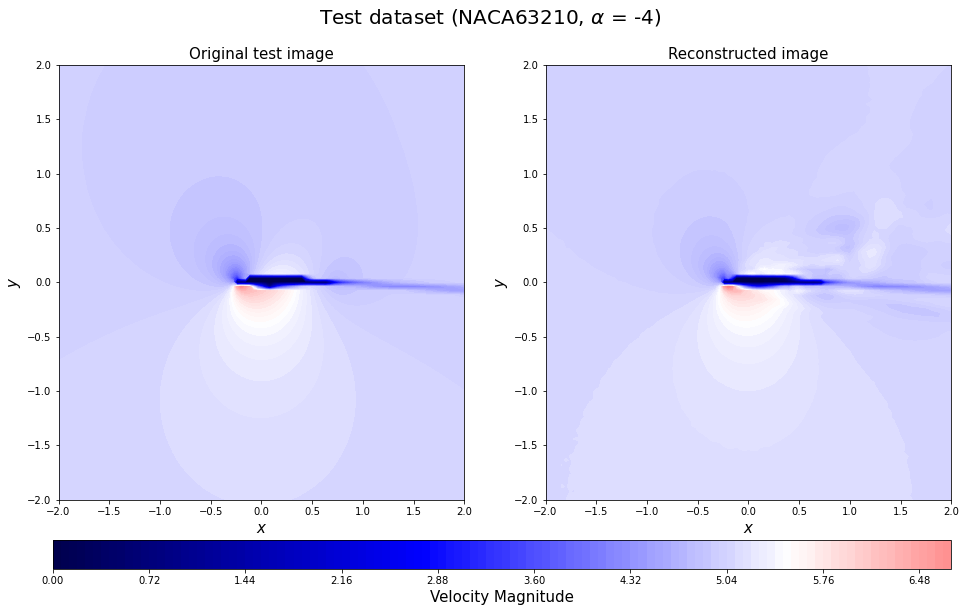

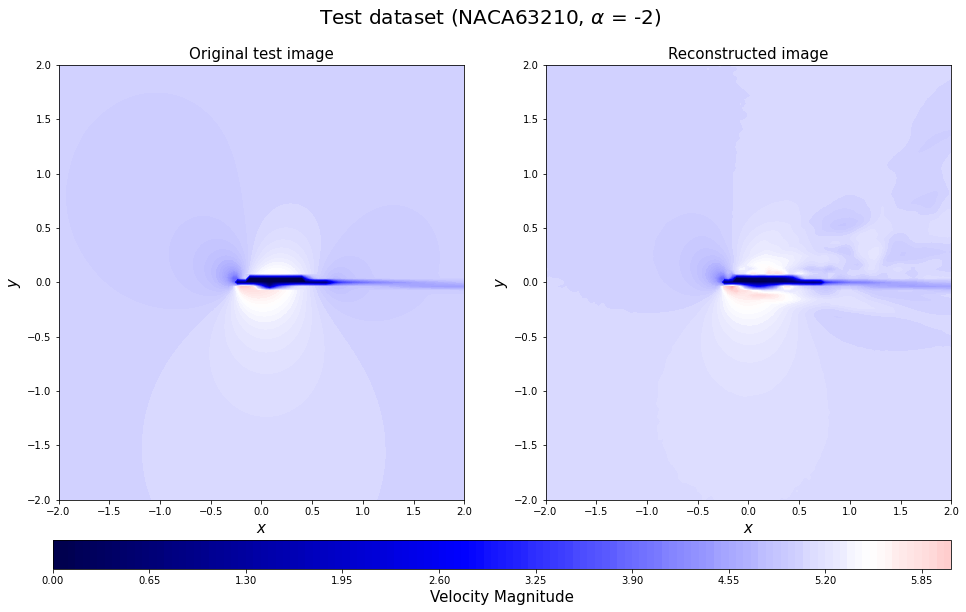

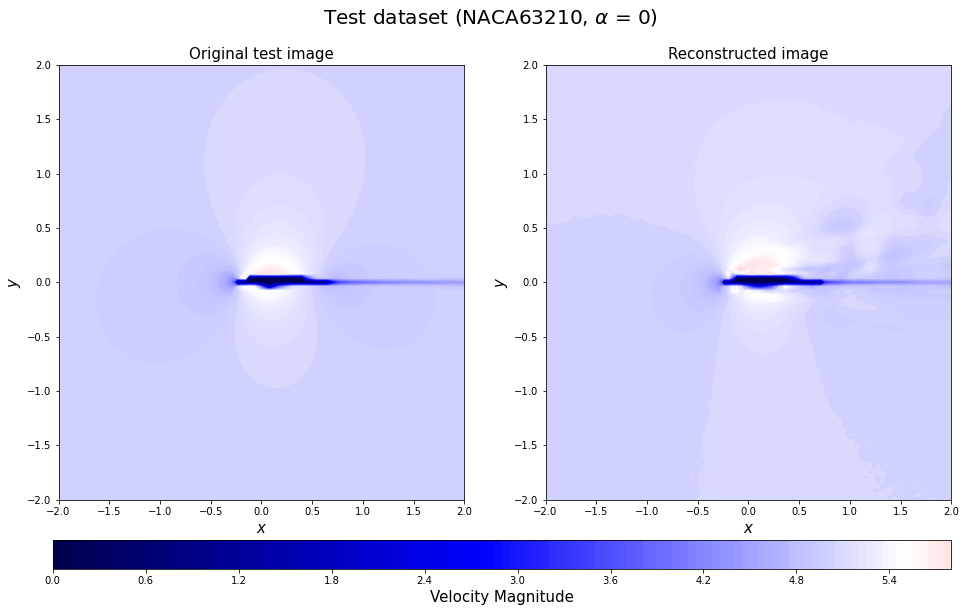

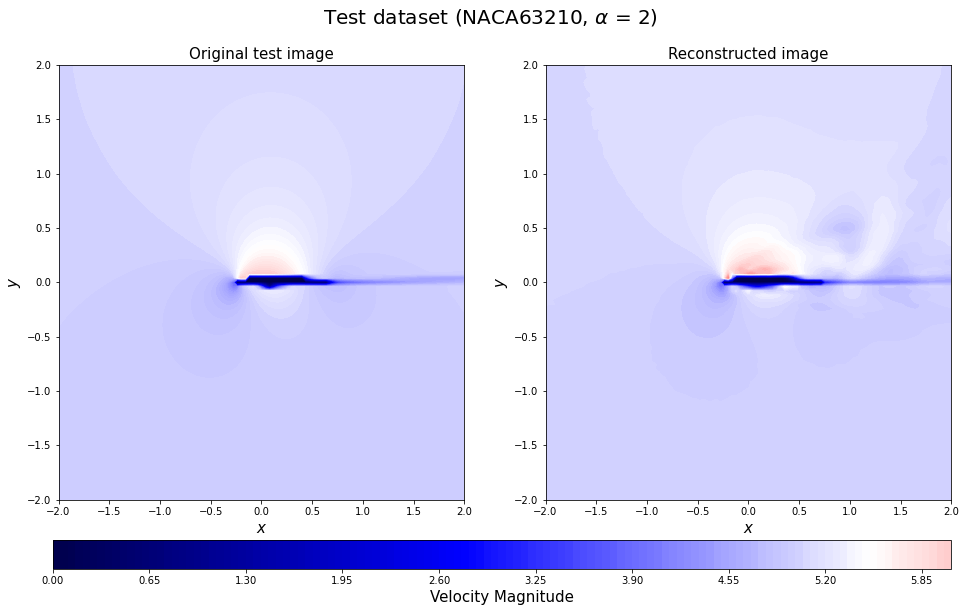

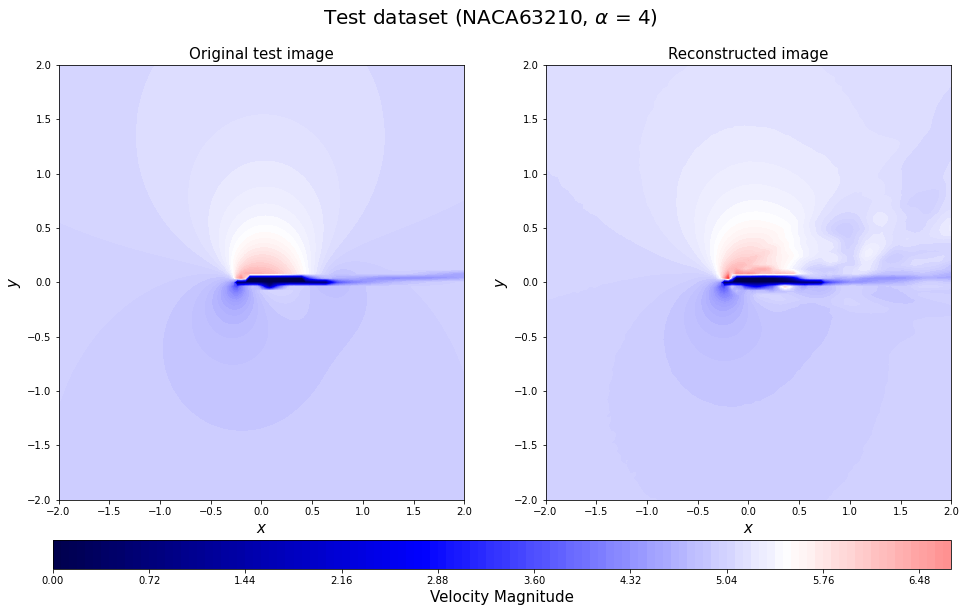

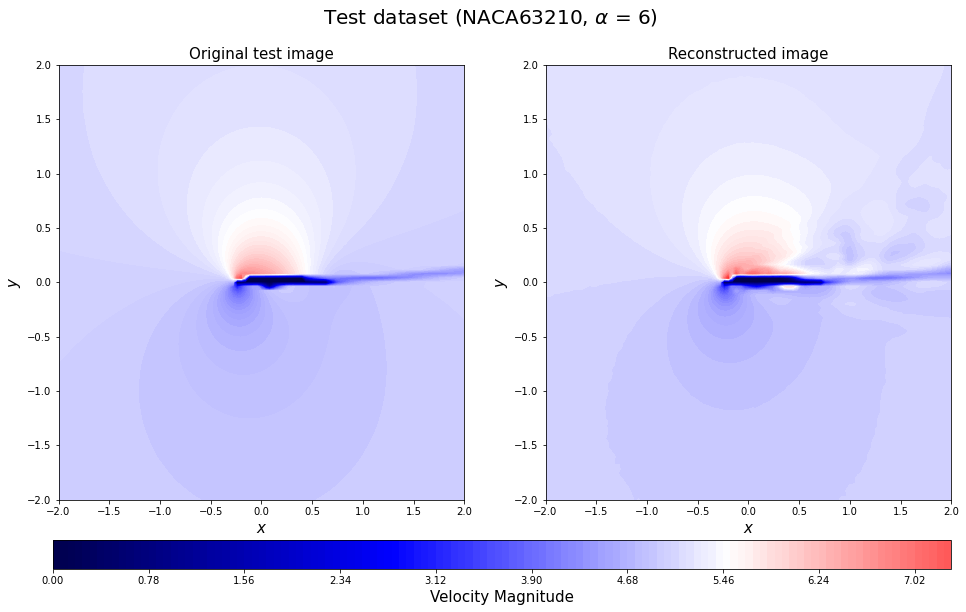

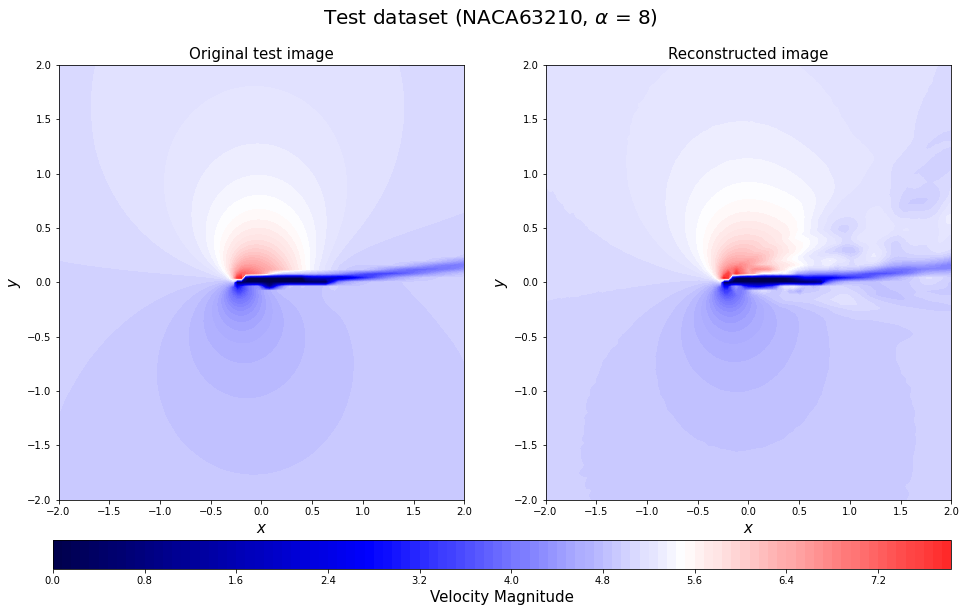

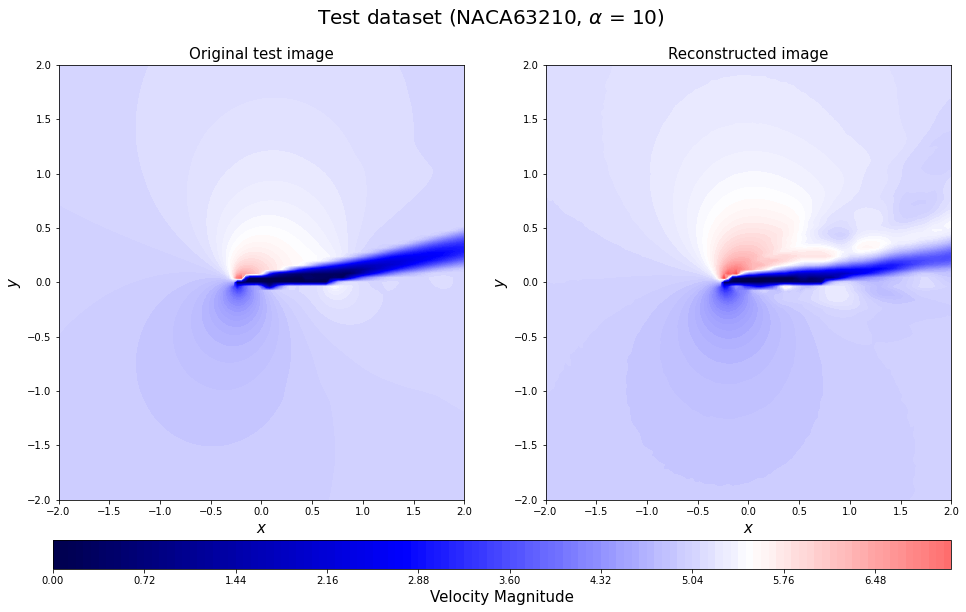

In [54]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[2*11+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[2*11+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[2*11+c])[3:-2], aa_test[2*11+c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[2*11+c])[3:-2])+str(aa_test[2*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

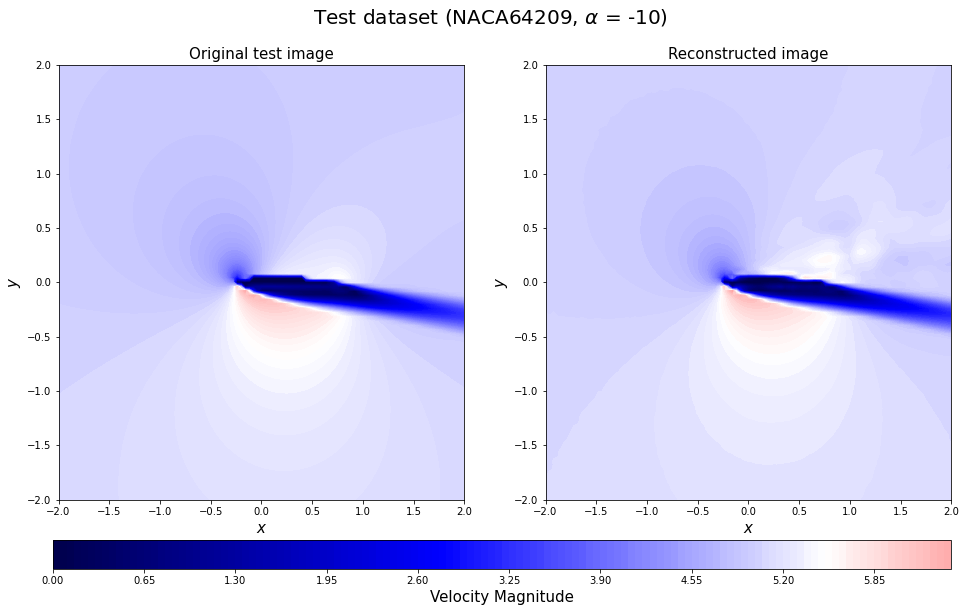

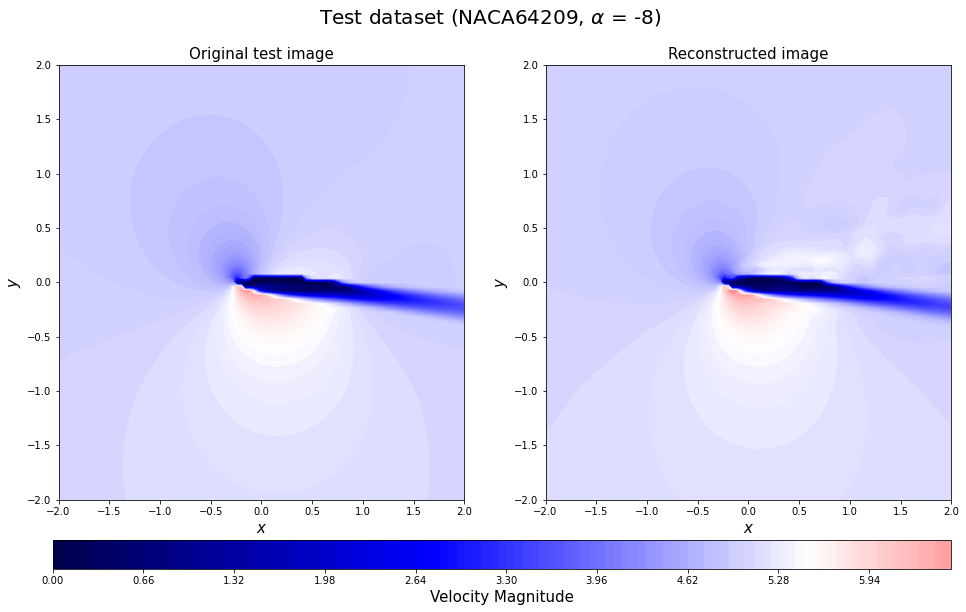

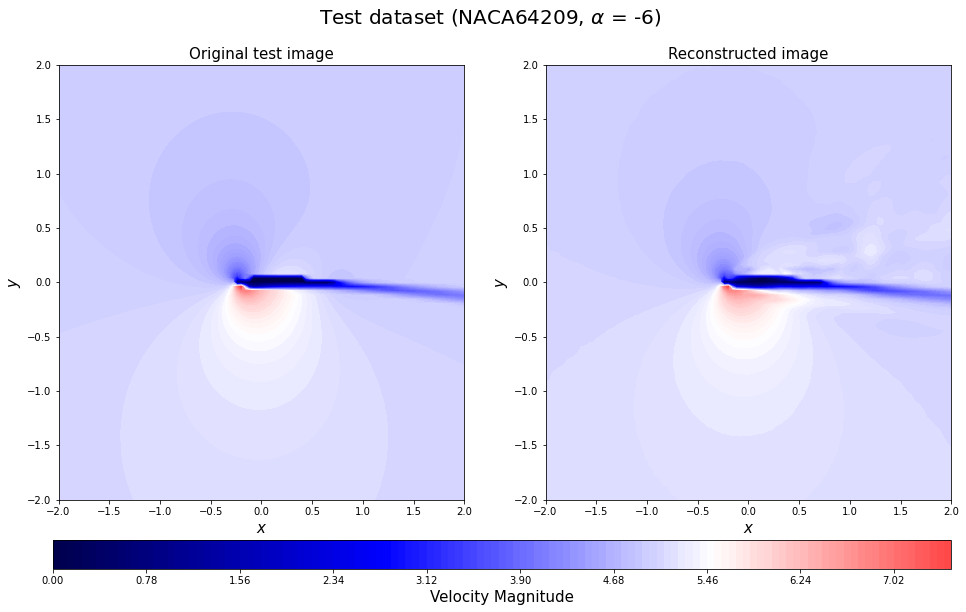

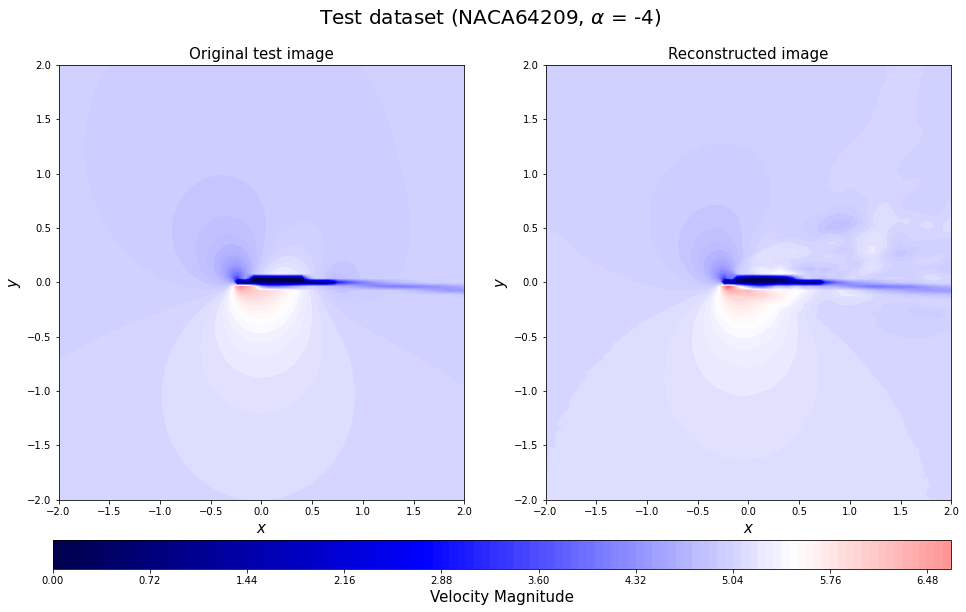

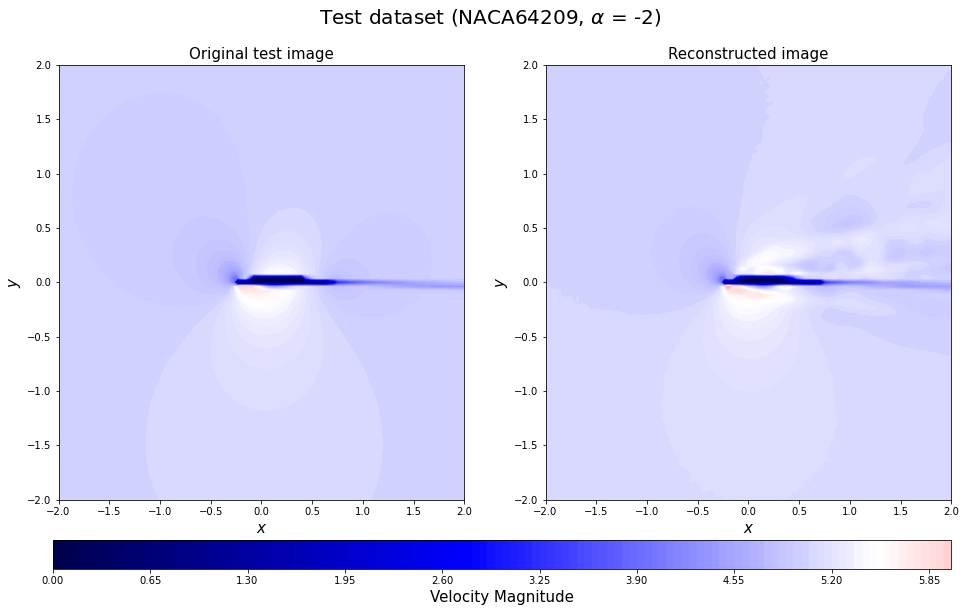

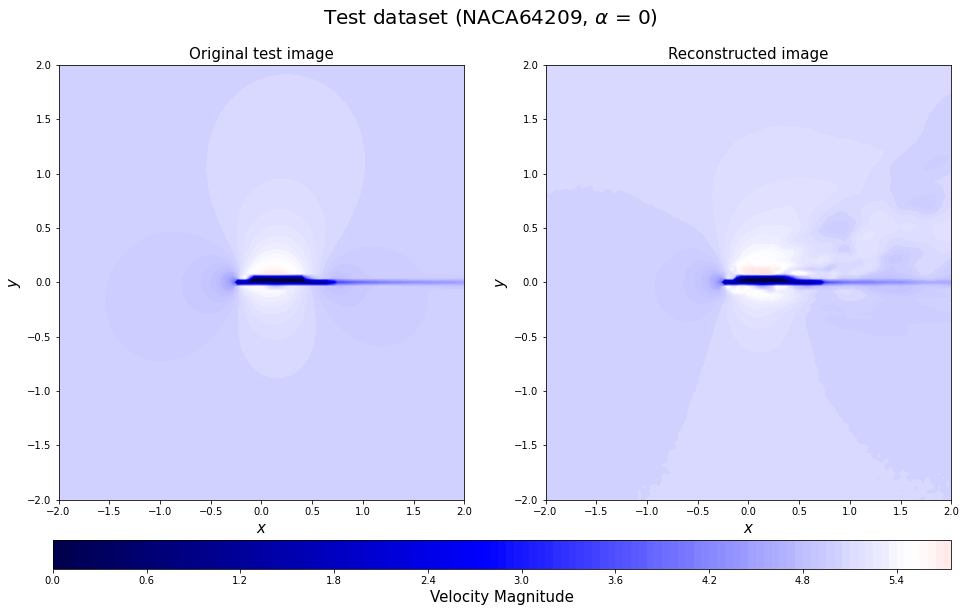

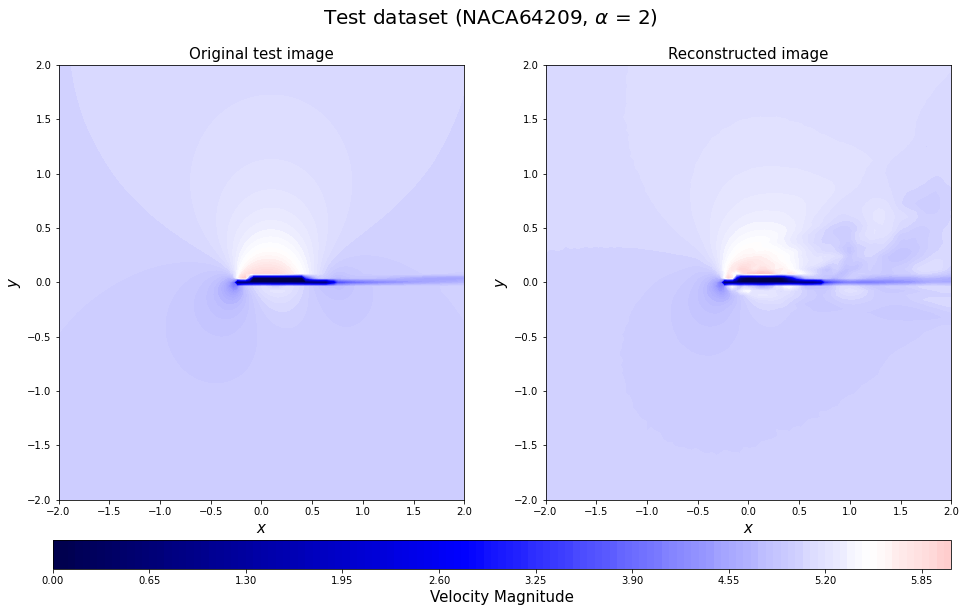

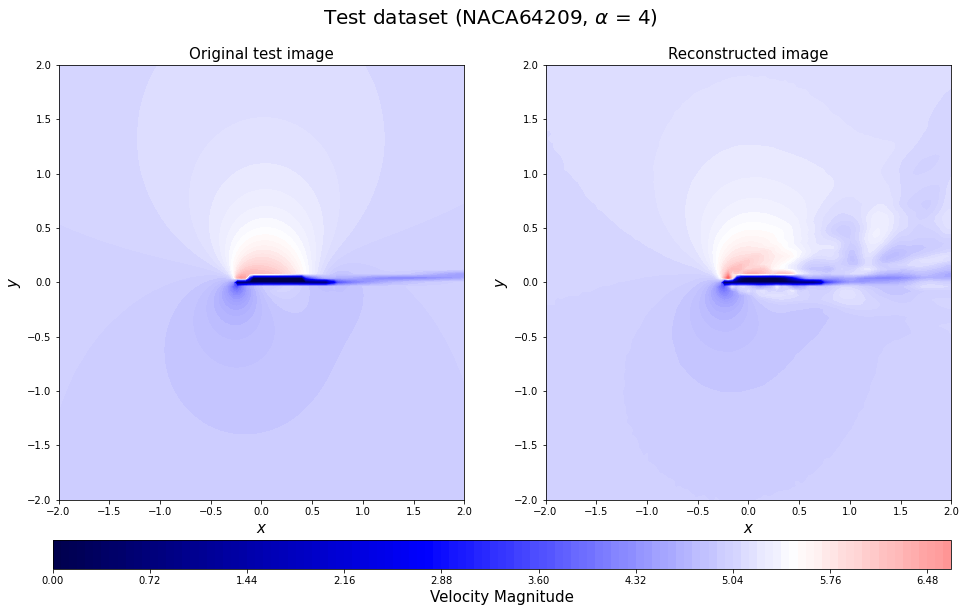

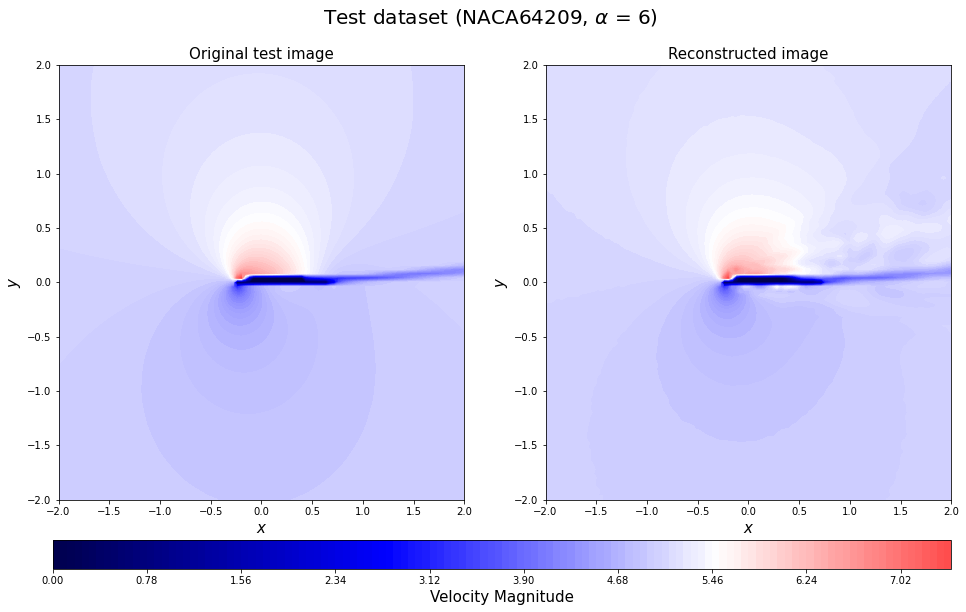

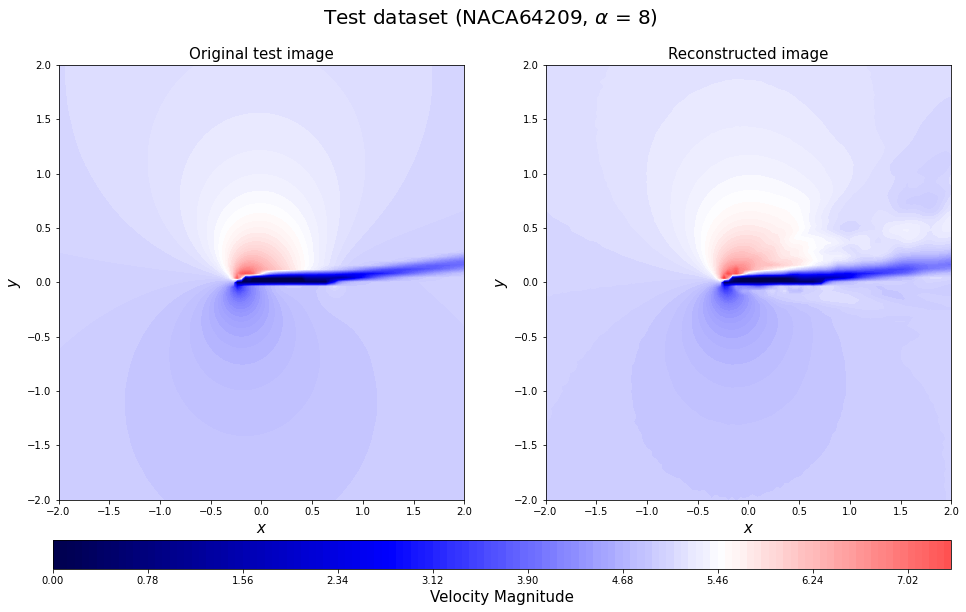

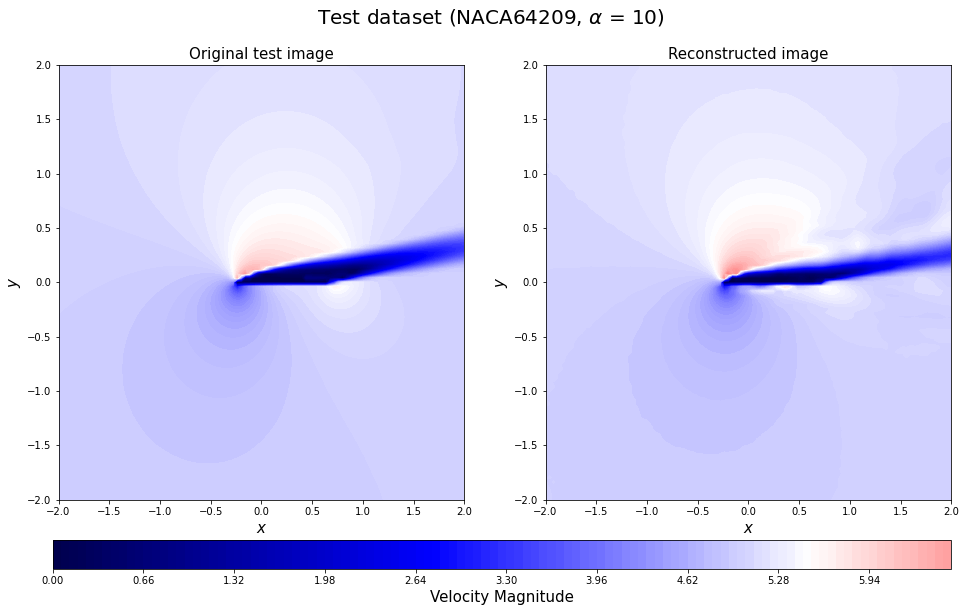

In [55]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_test0_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

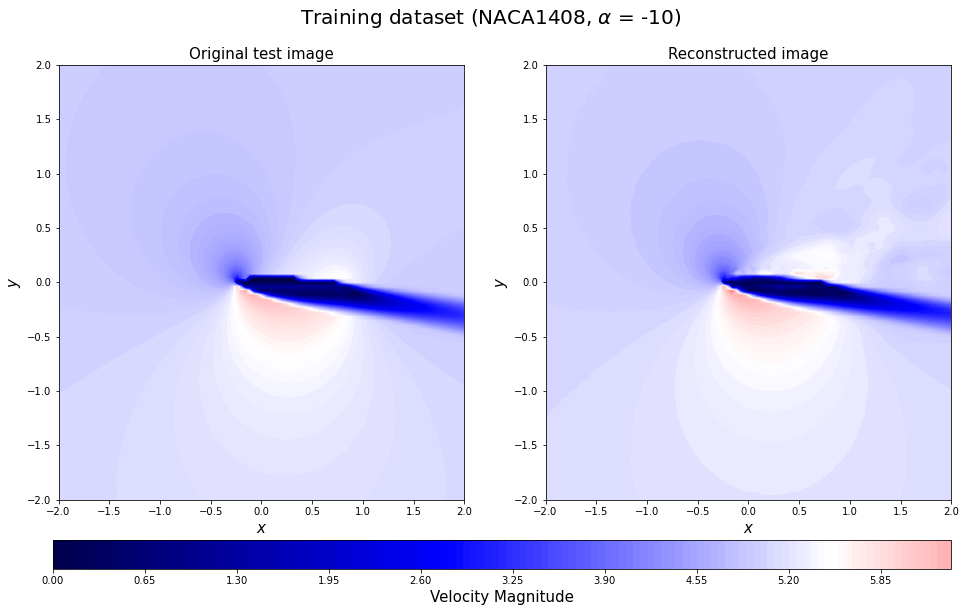

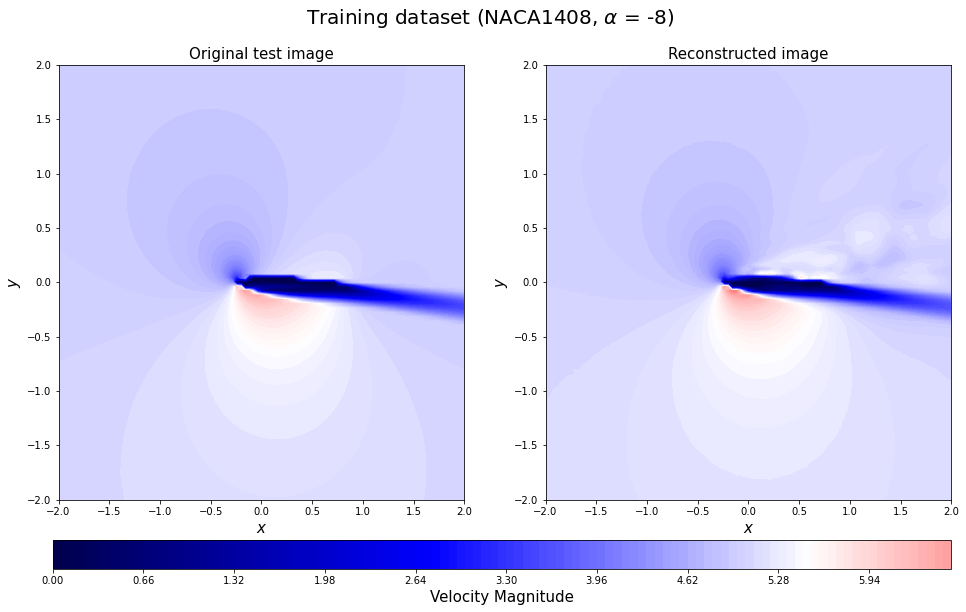

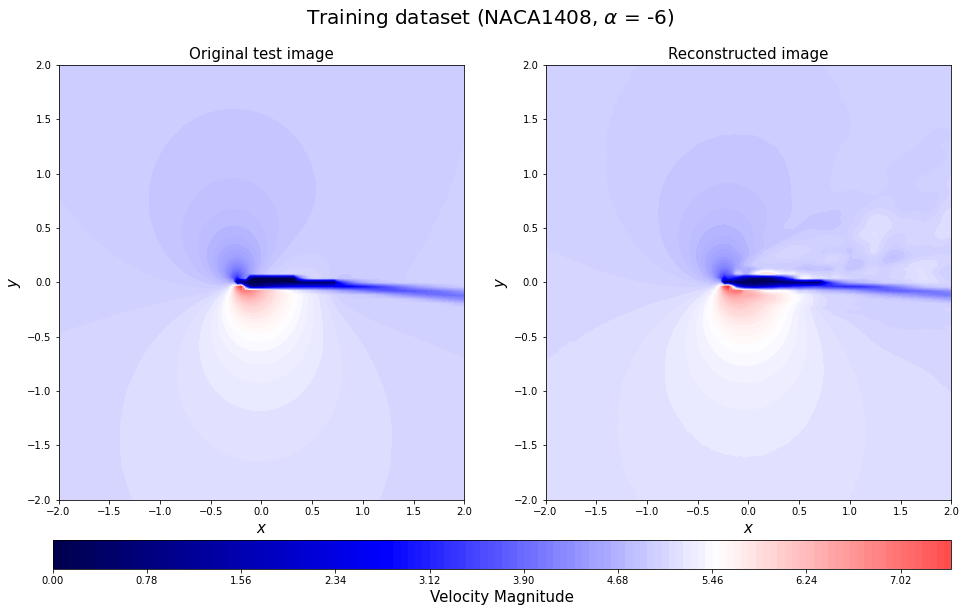

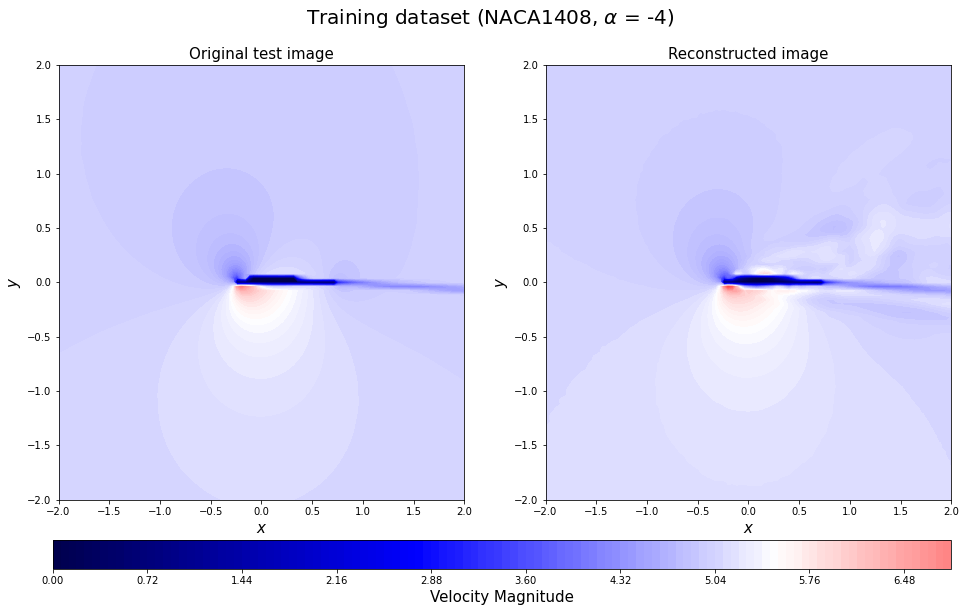

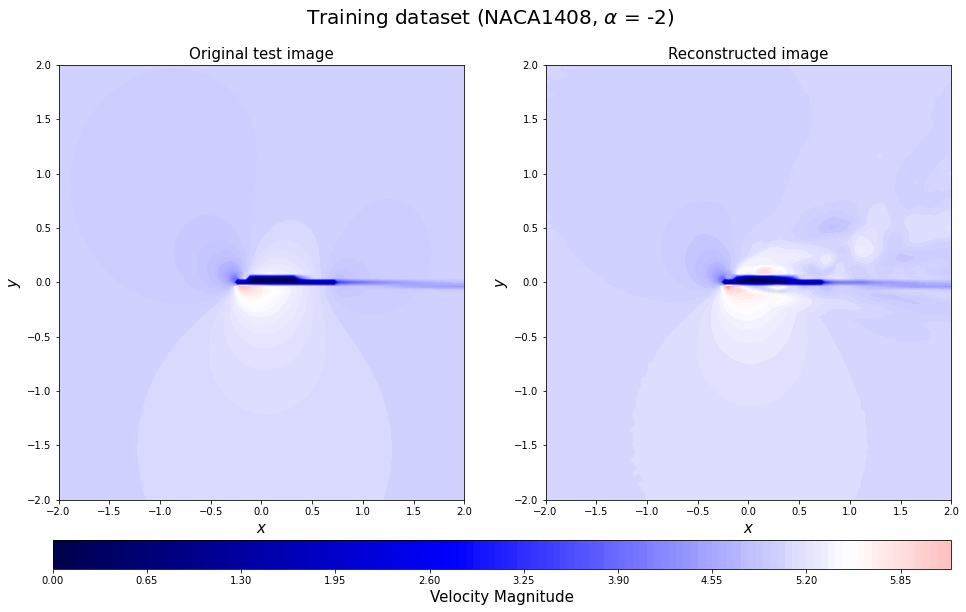

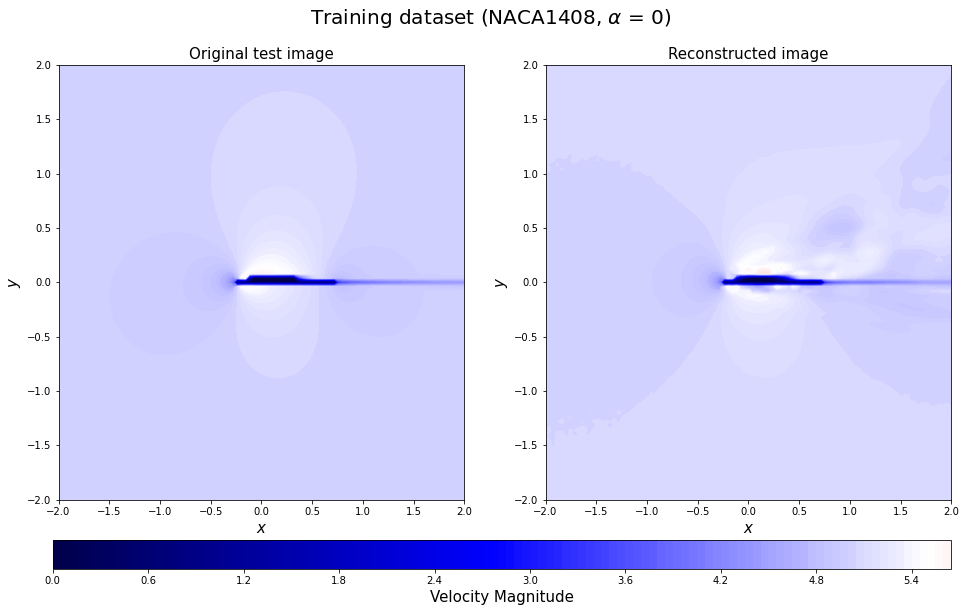

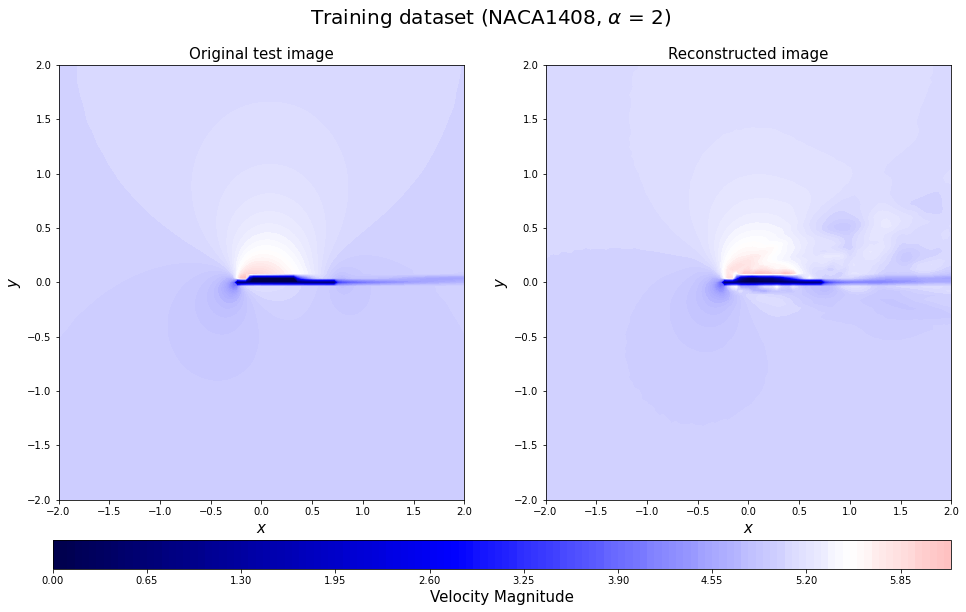

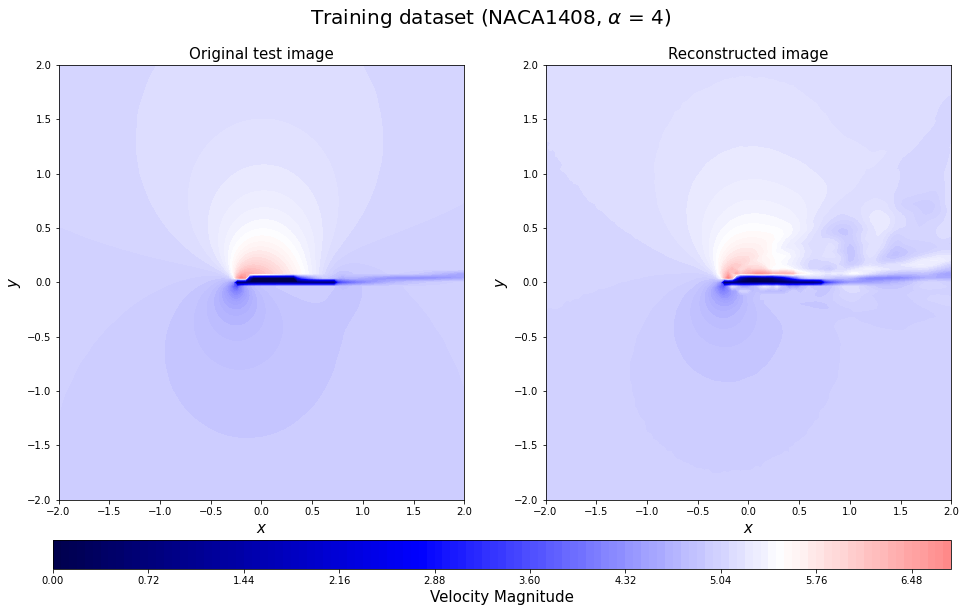

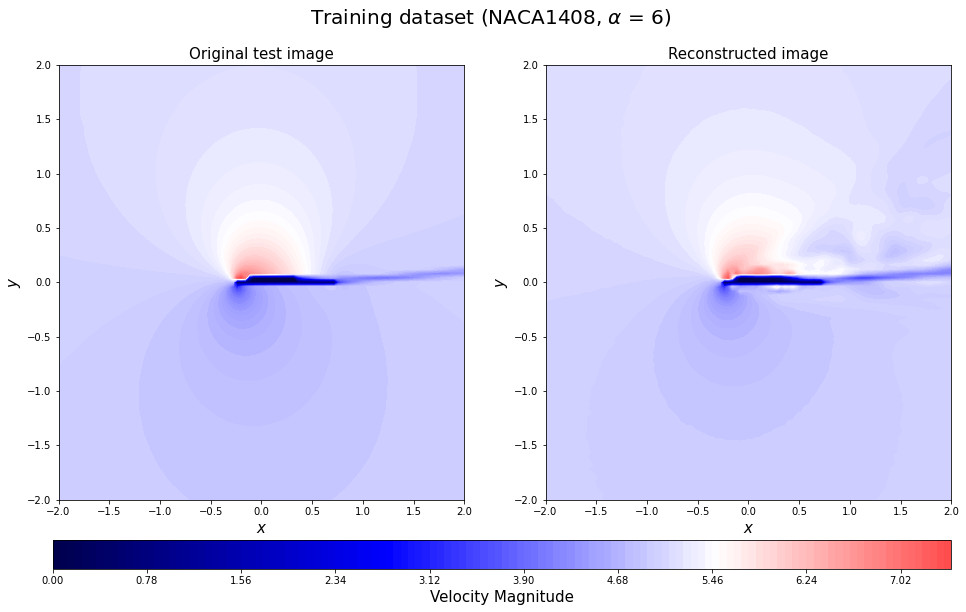

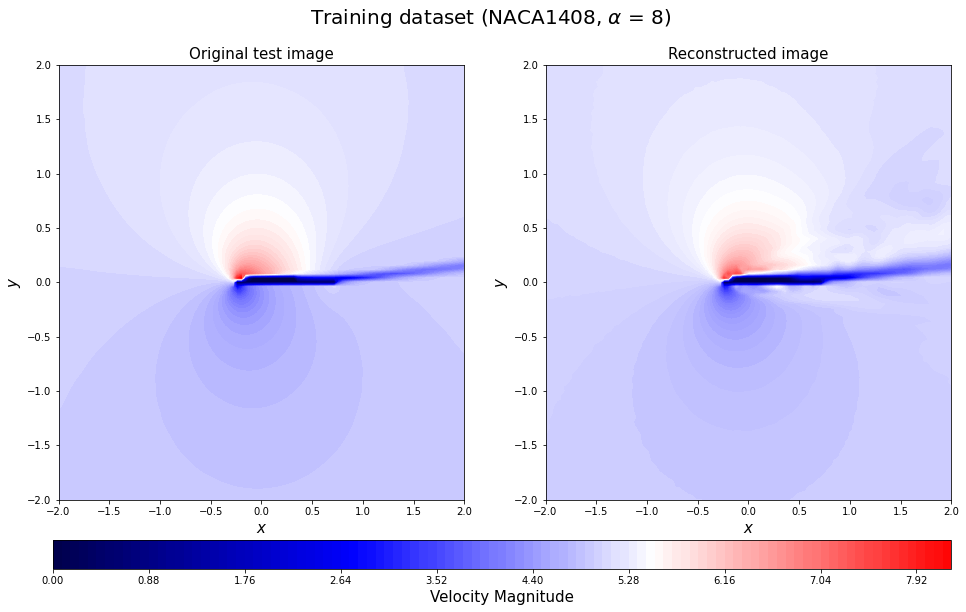

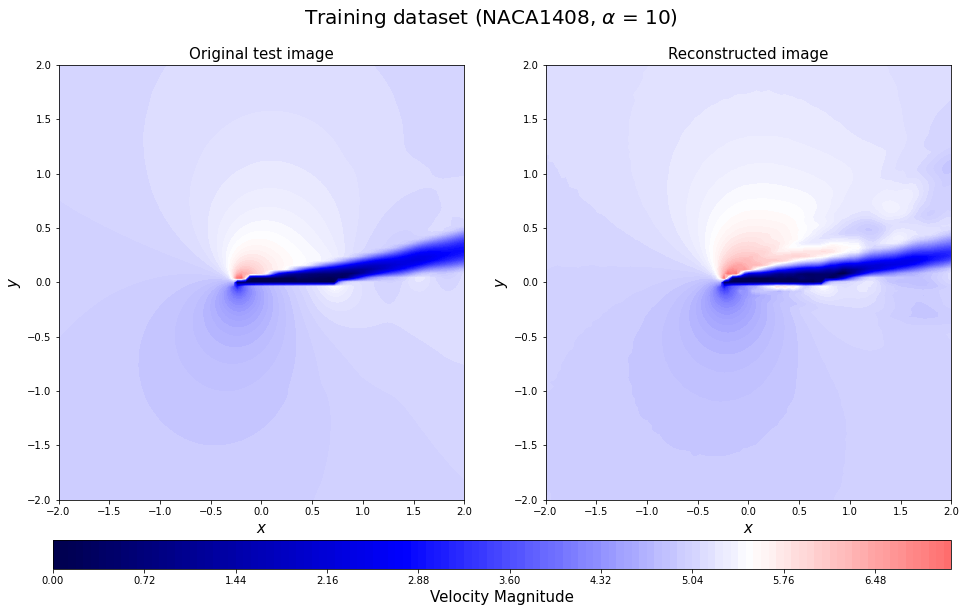

In [56]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

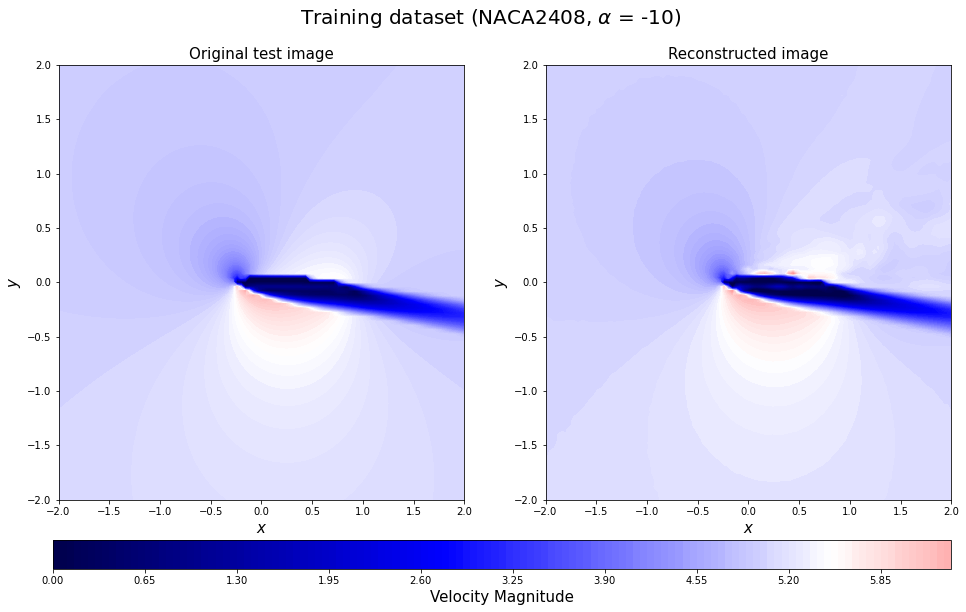

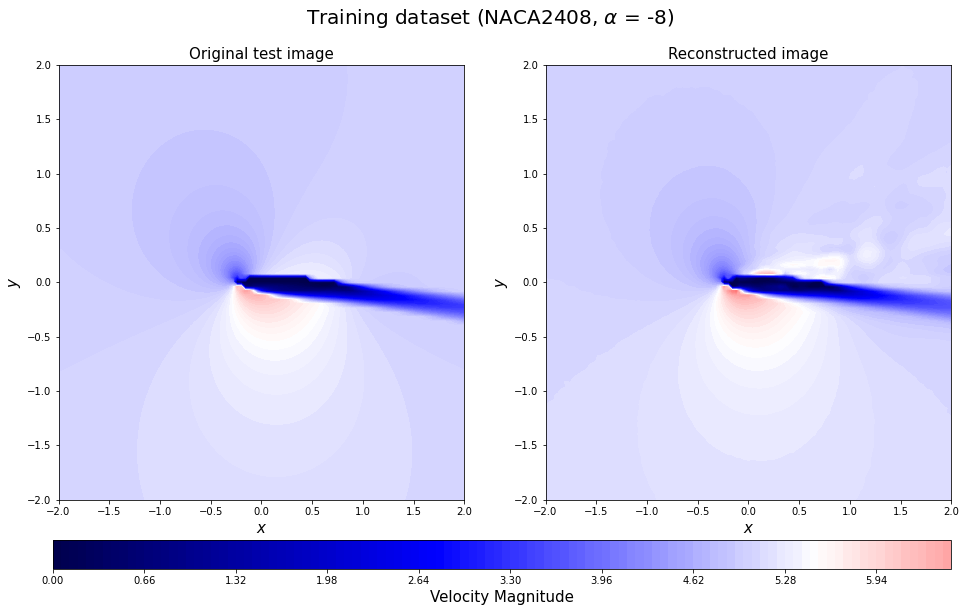

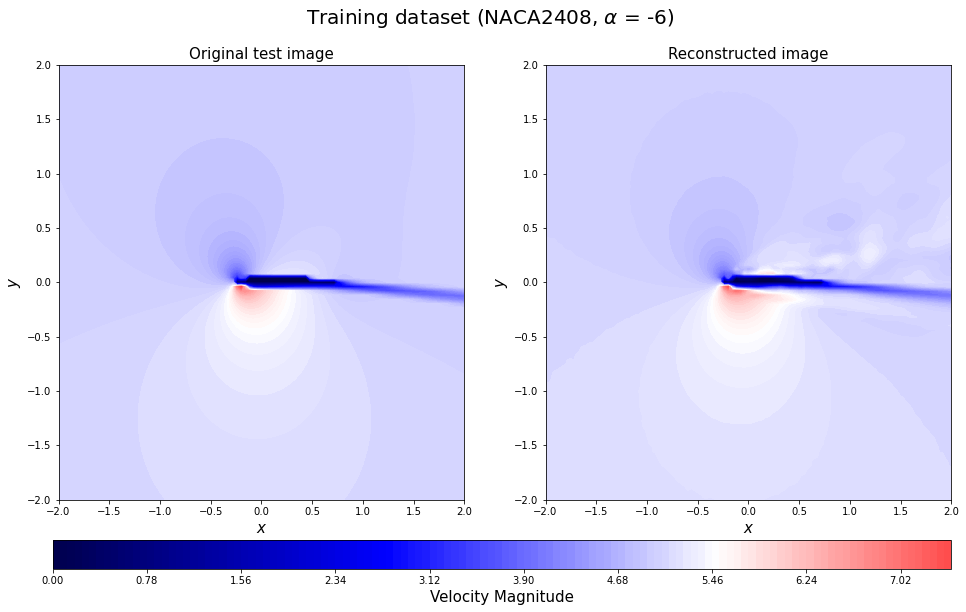

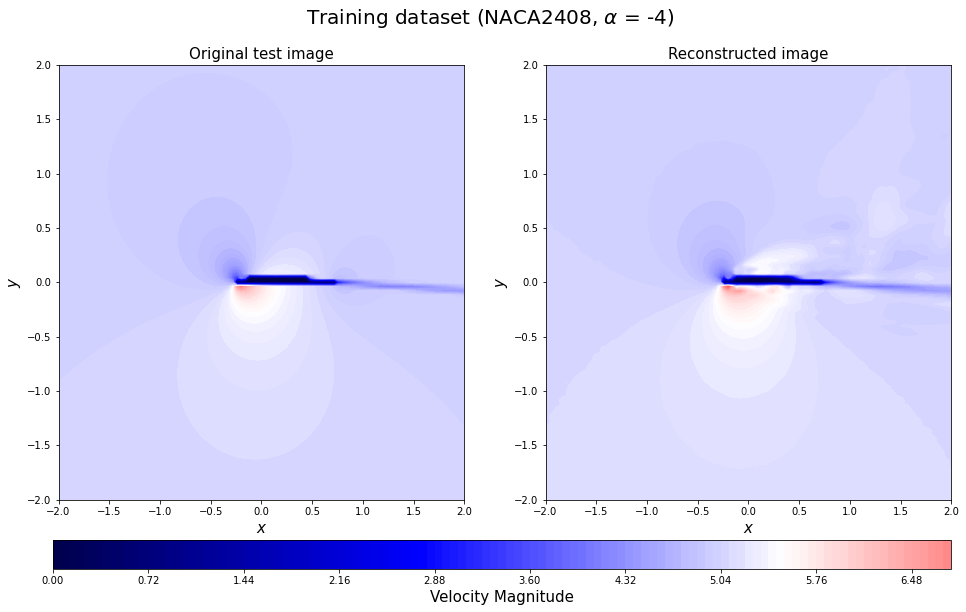

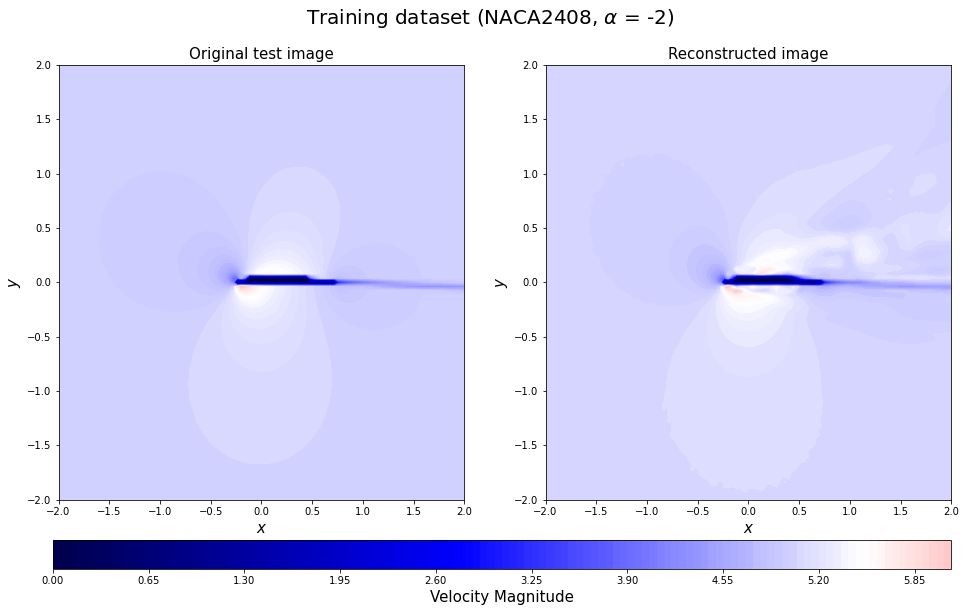

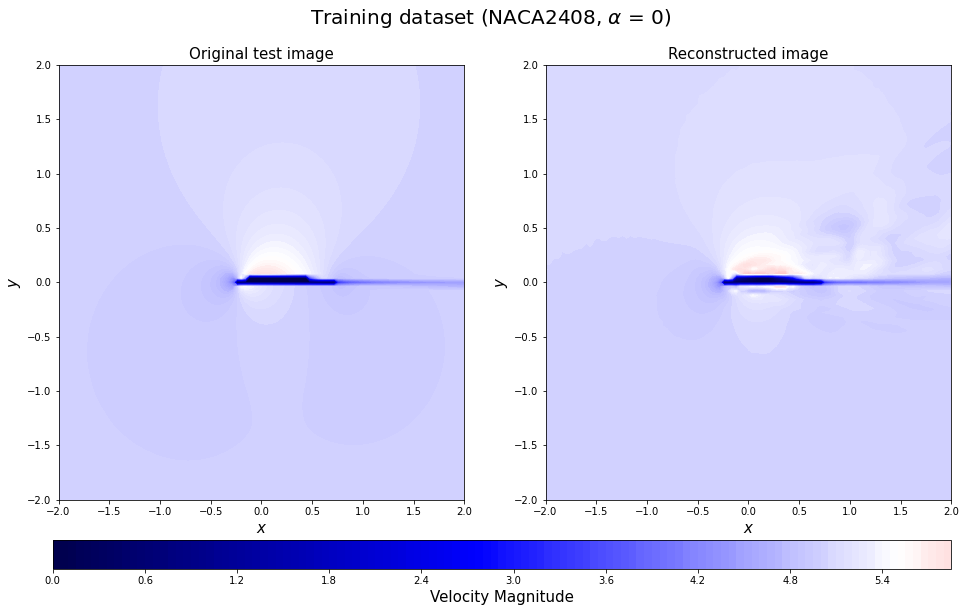

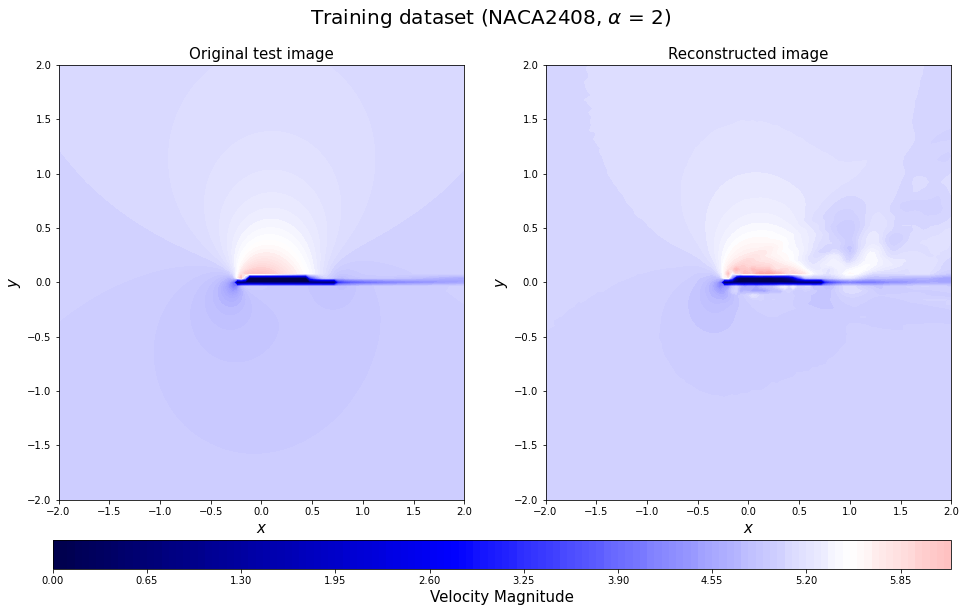

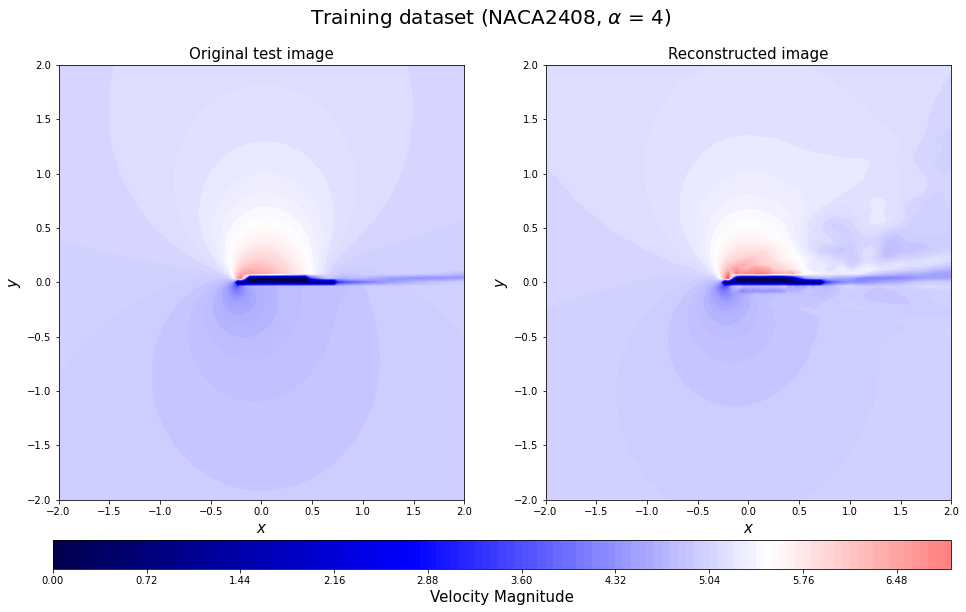

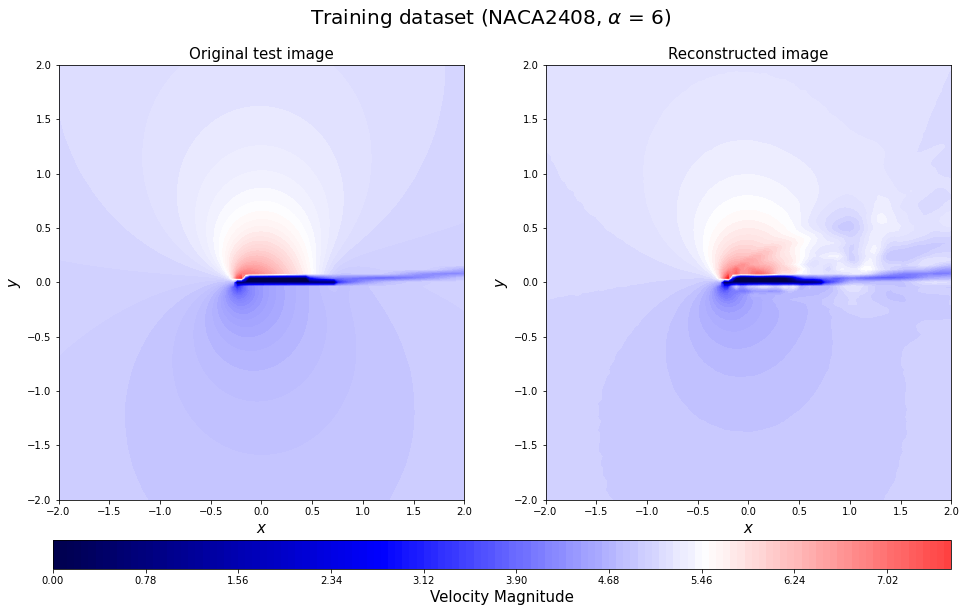

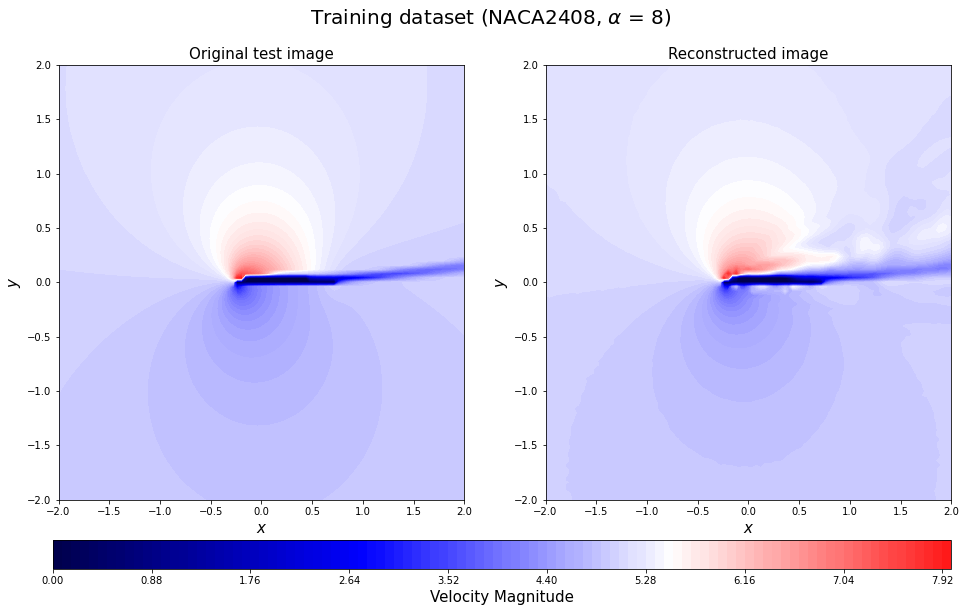

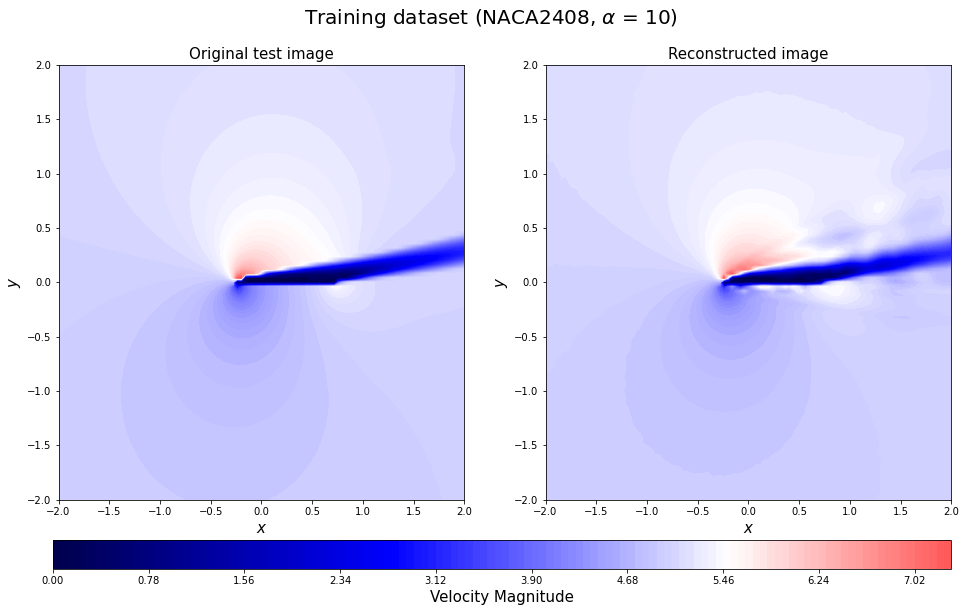

In [57]:
for c in range(0,11):
    plt.figure(figsize=(16, 8))
    y_train20_rotate = y_train[20*11+c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[20*11+c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train20_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=0, vmax=11, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[20*11+c])[3:-2], aa_train[20*11+c]),fontsize=20)
    save_fig_name = "20221019Prediction_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[20*11+c])[3:-2])+str(aa_train[20*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

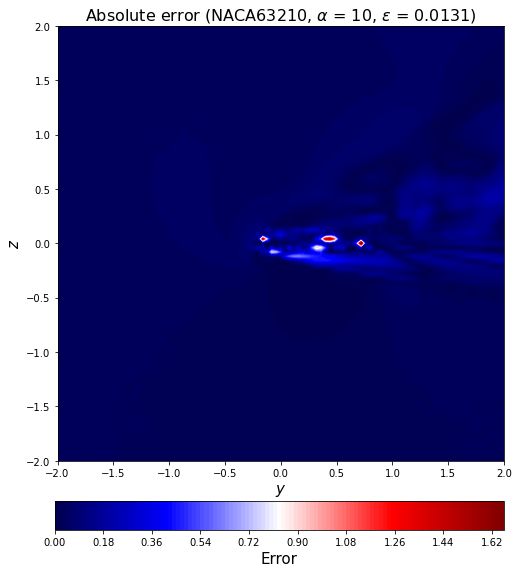

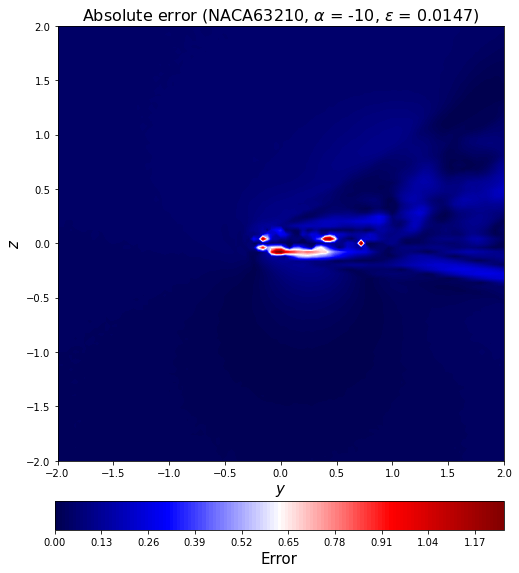

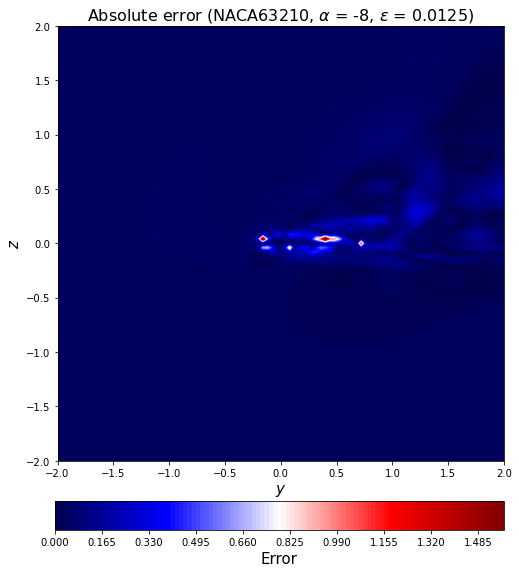

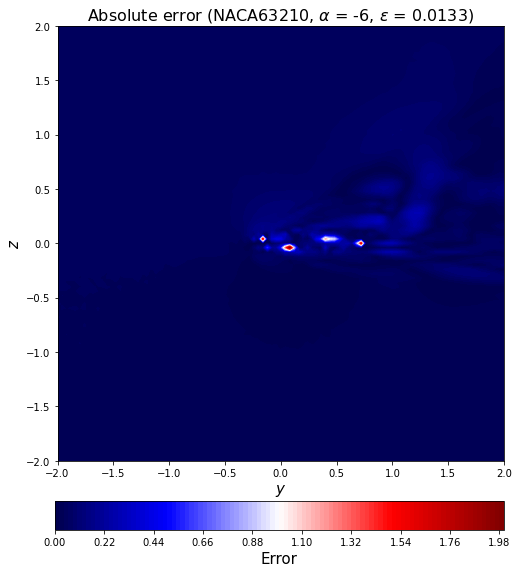

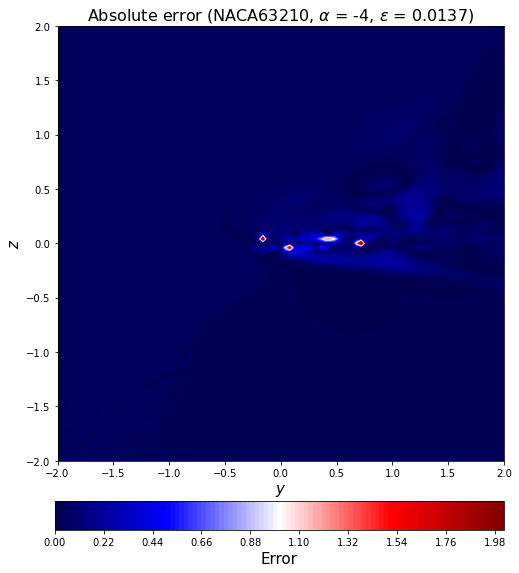

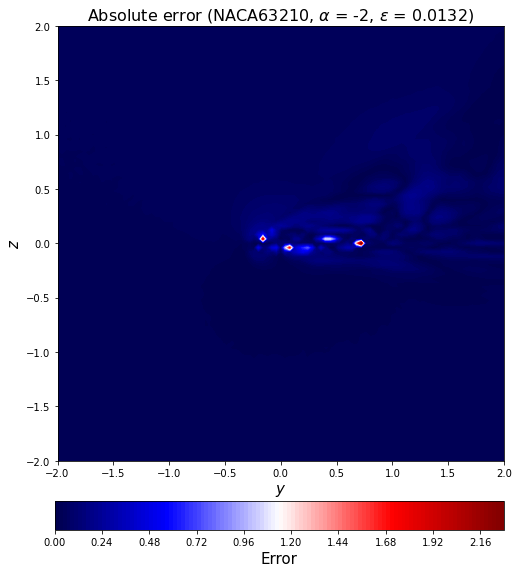

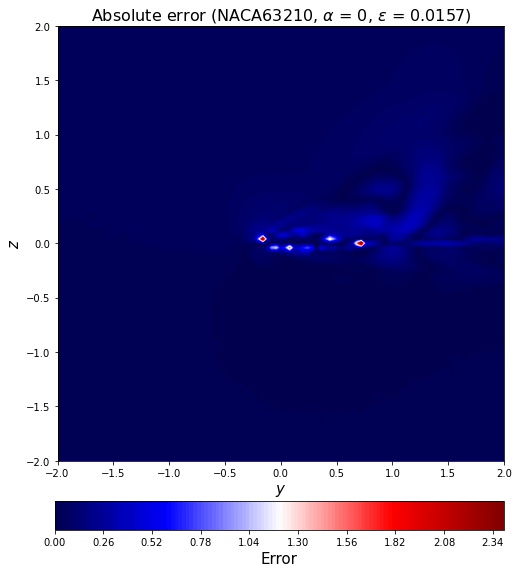

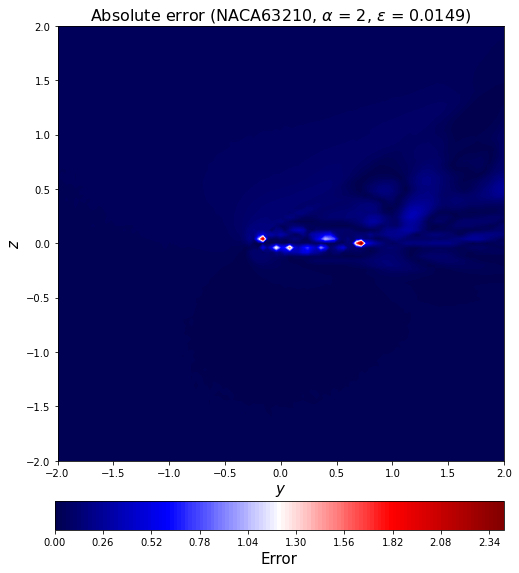

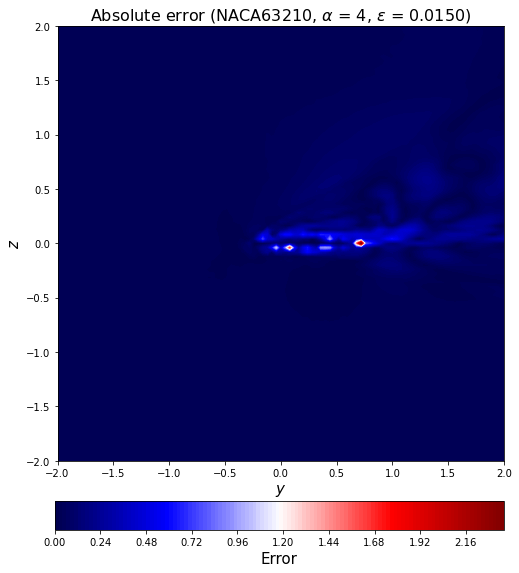

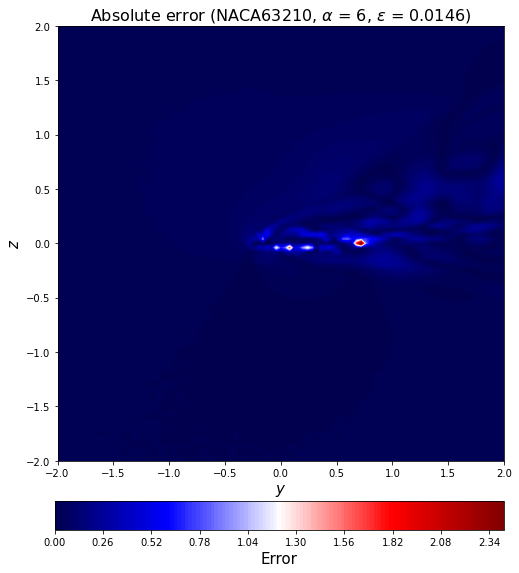

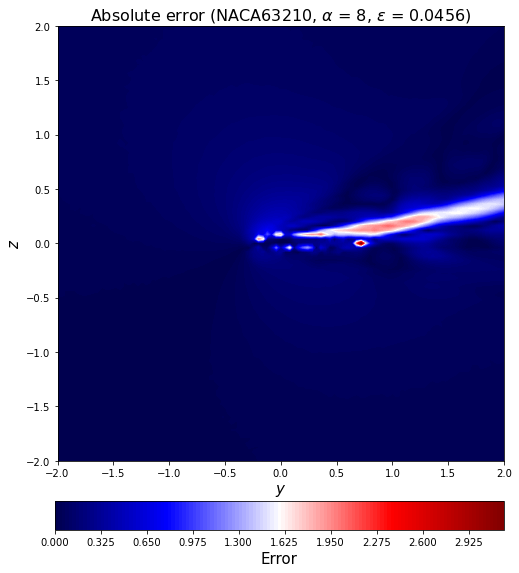

In [58]:
for c in range(0,11):
    error_test_abs2_rotate = error_test_abs[2*11+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[2*11+c])[3:-2],
                                                                       aa_test[2*16+c], l2_error_test_list[2*11+c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[2*11+c])[3:-2])+str(aa_test[2*11+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

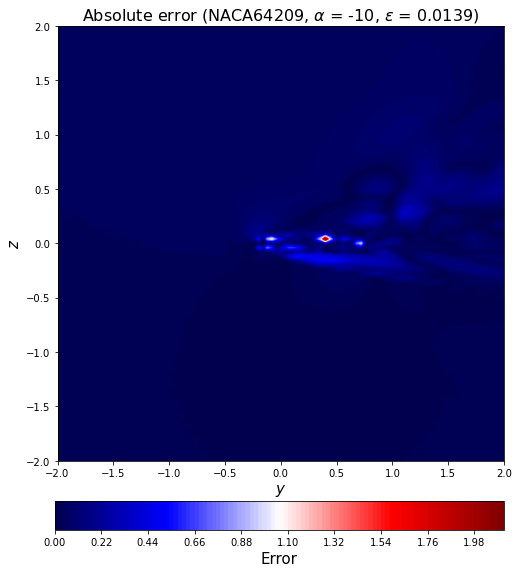

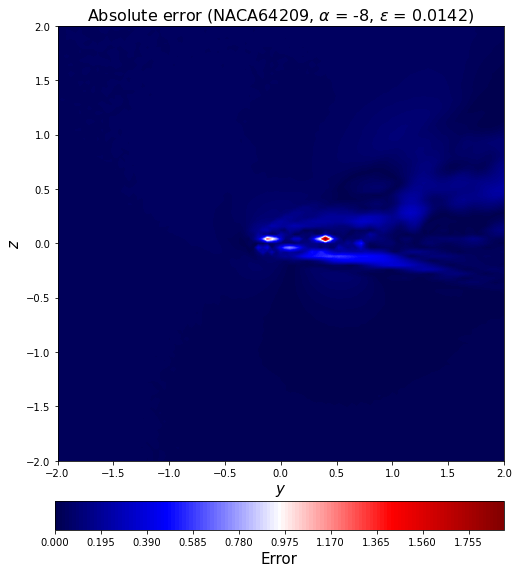

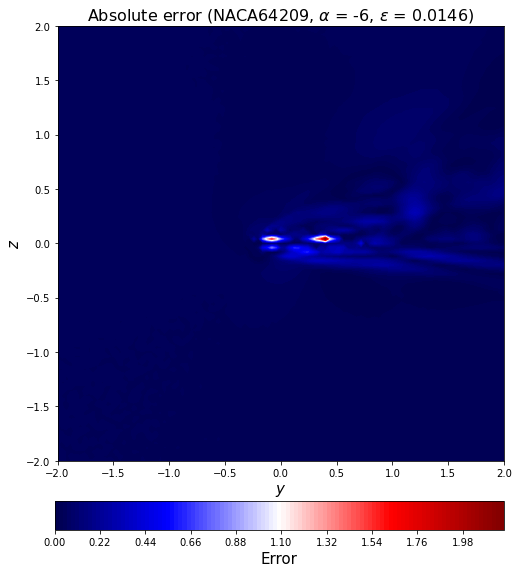

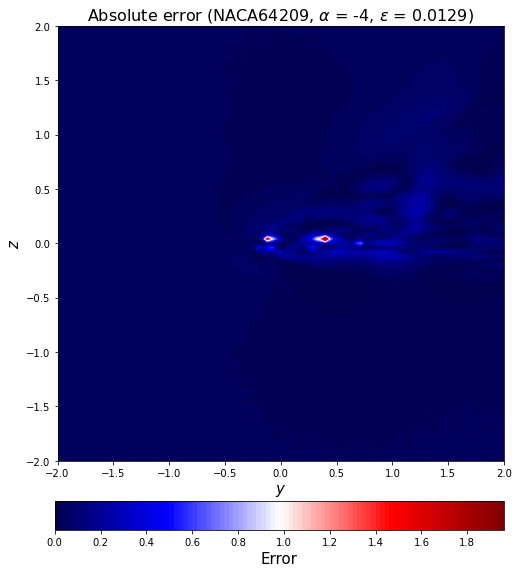

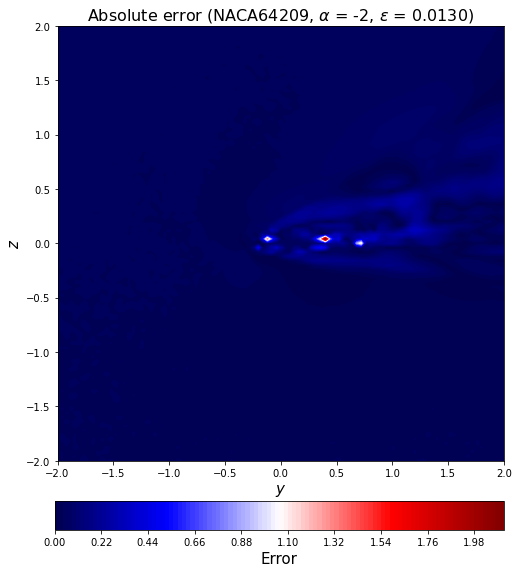

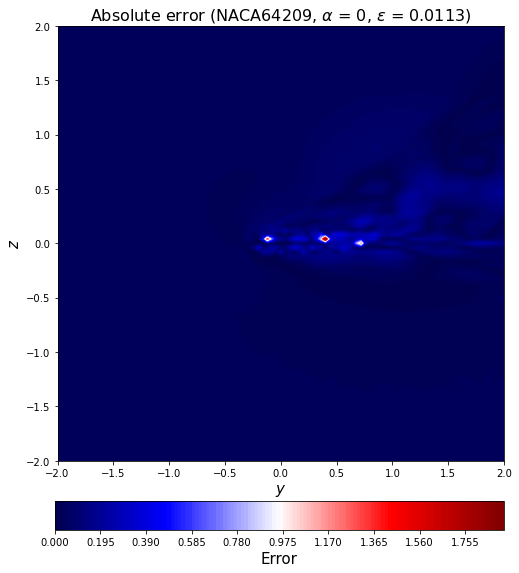

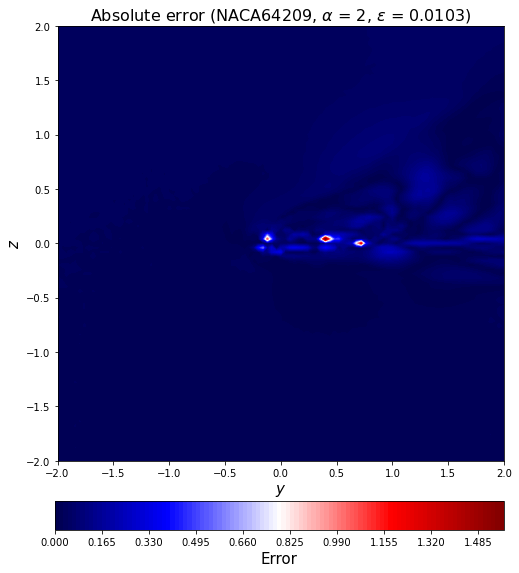

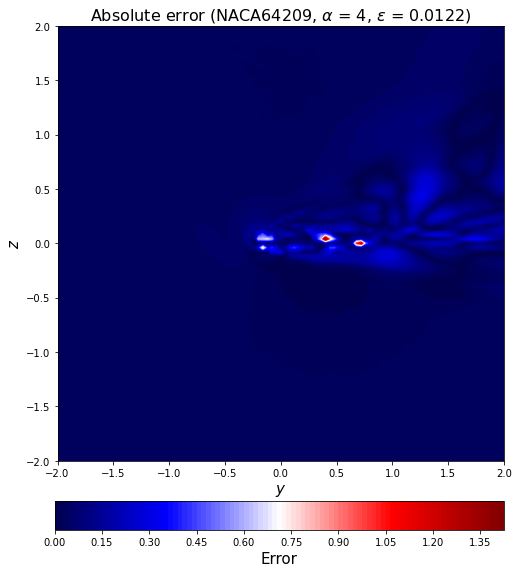

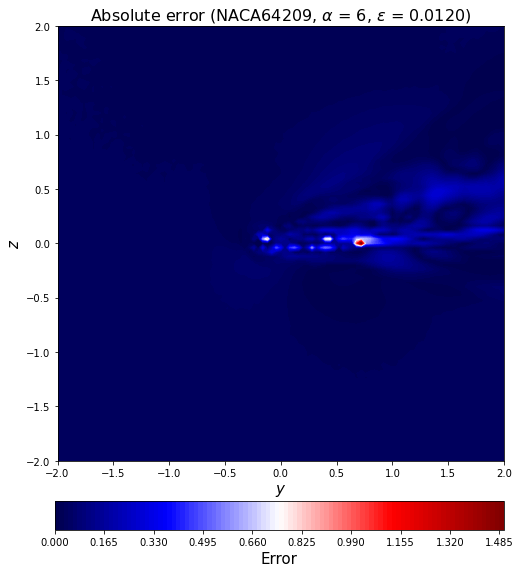

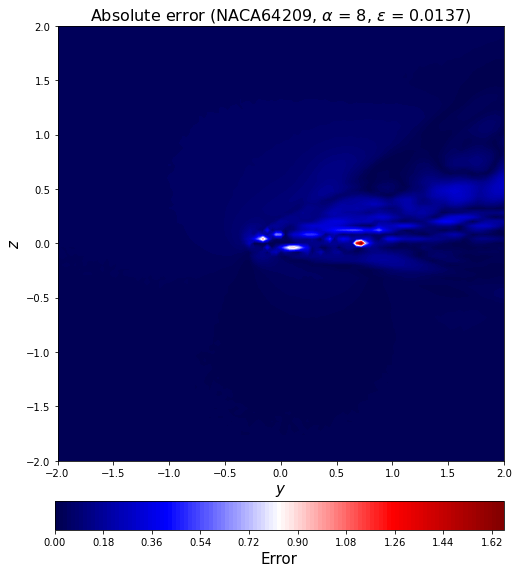

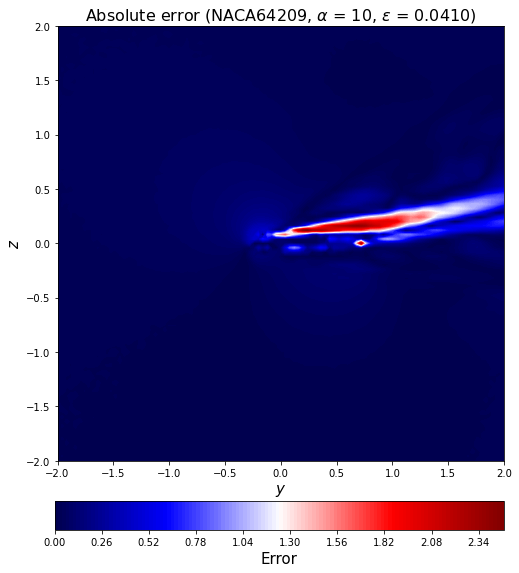

In [59]:
for c in range(0,11):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(test)"+str(np.array2string(geo_test[c])[3:-2])+str(aa_test[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

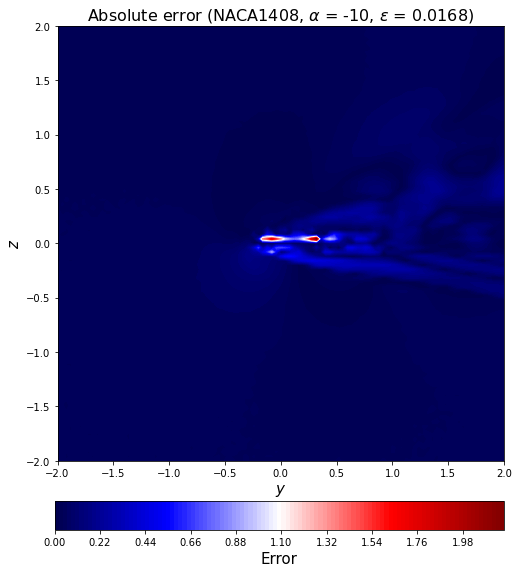

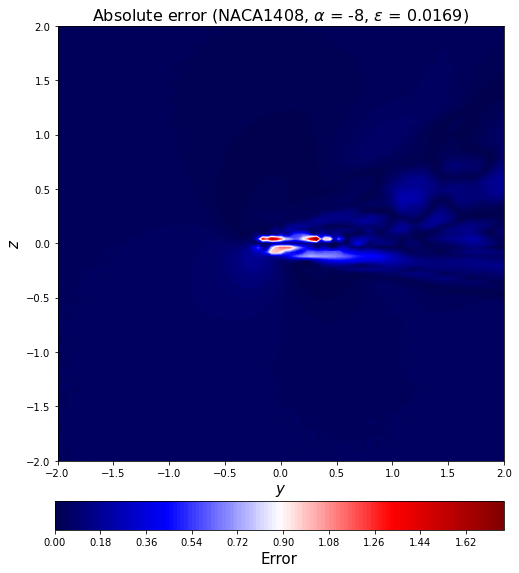

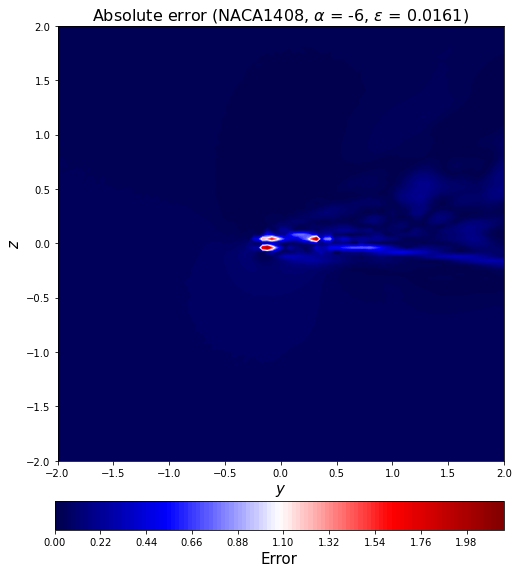

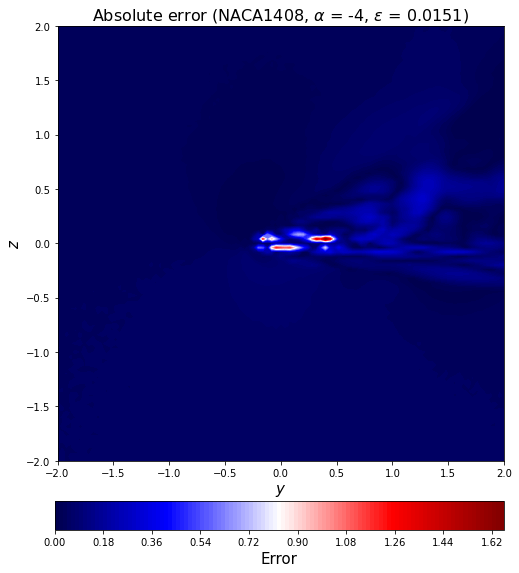

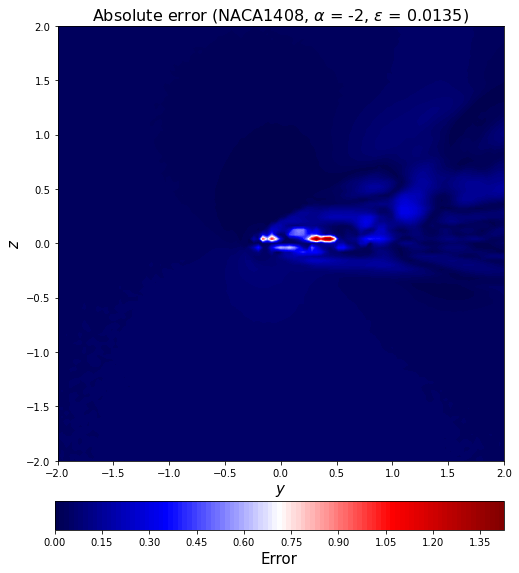

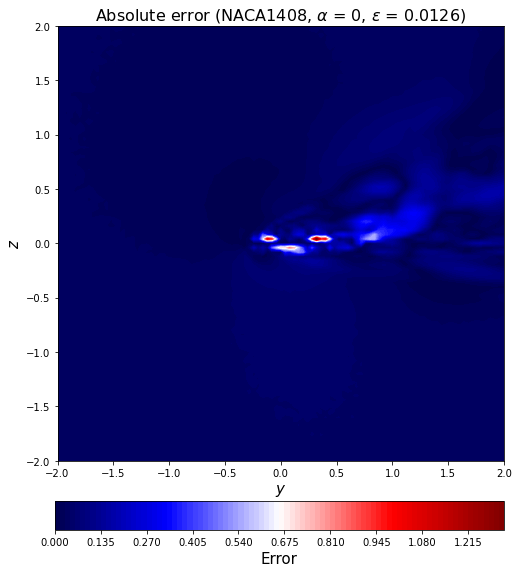

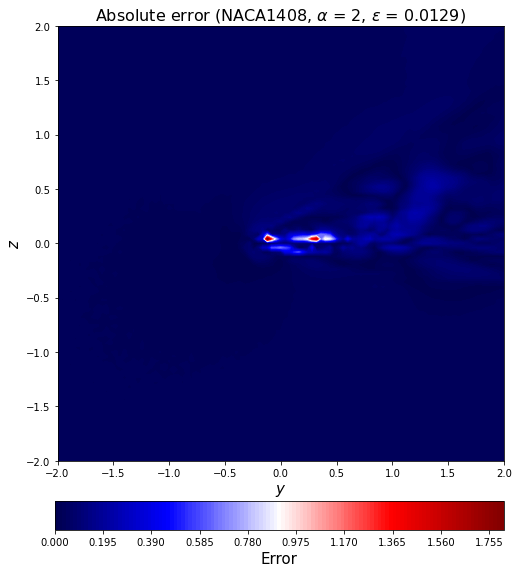

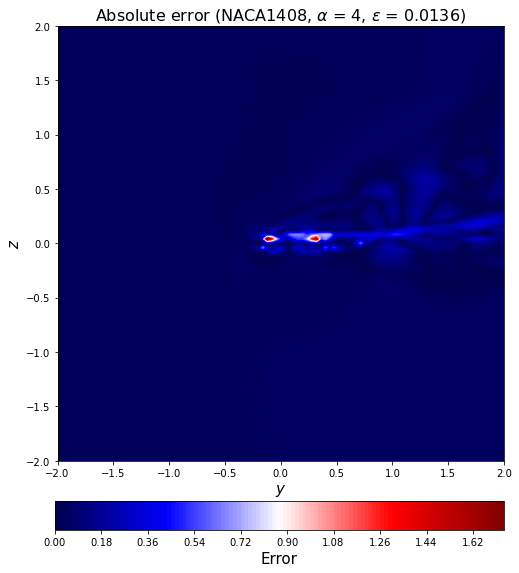

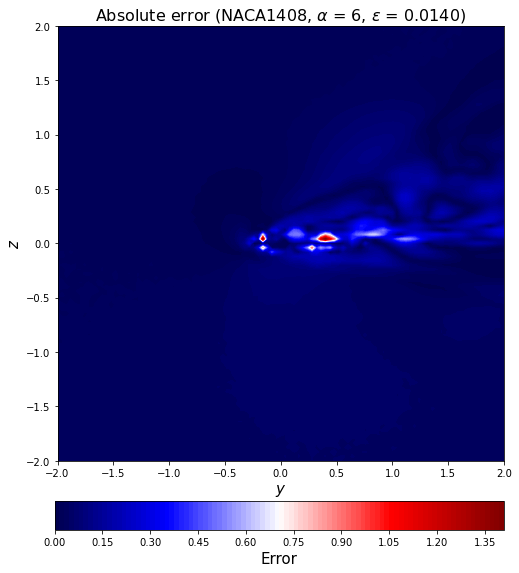

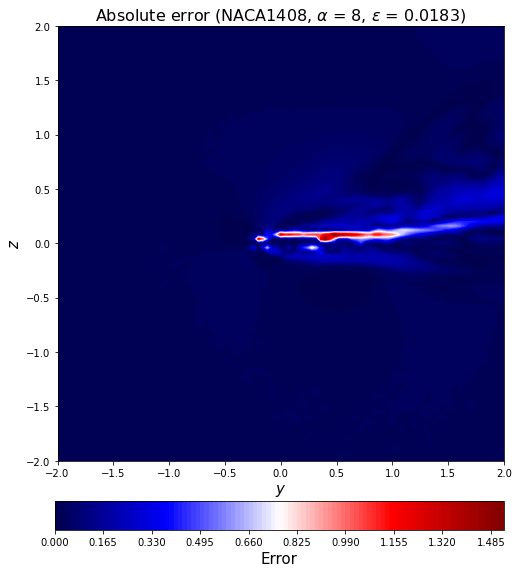

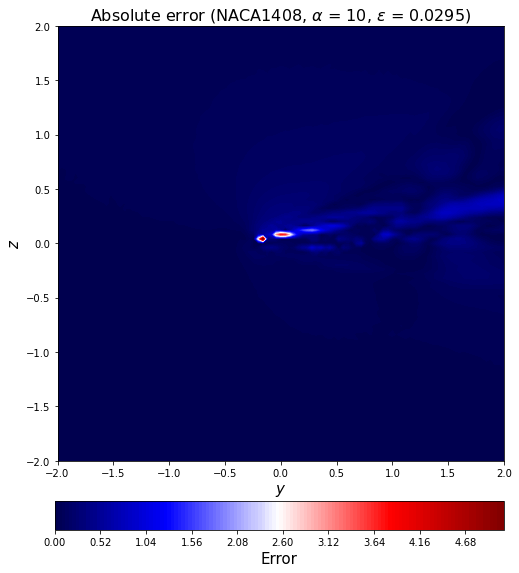

In [60]:
for c in range(0,11):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                             aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[c])[3:-2])+str(aa_train[c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

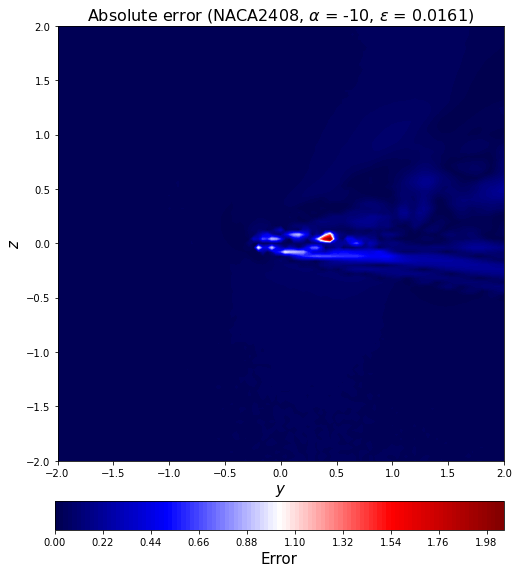

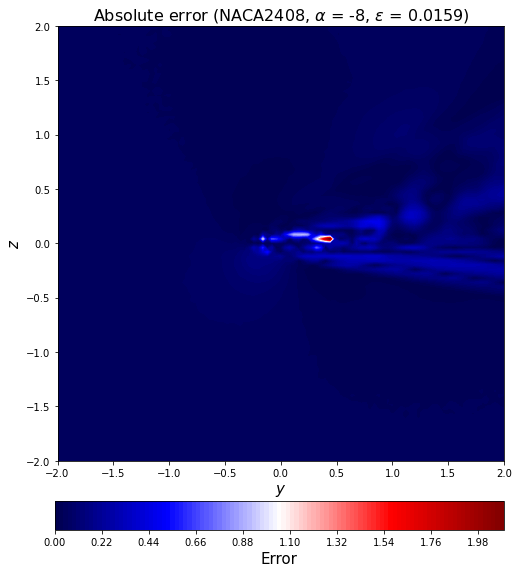

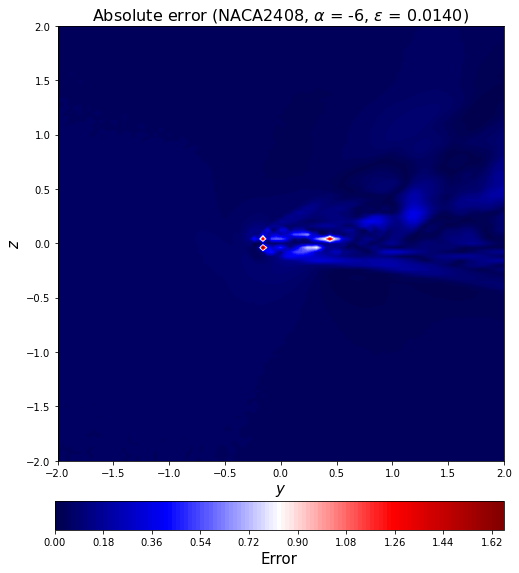

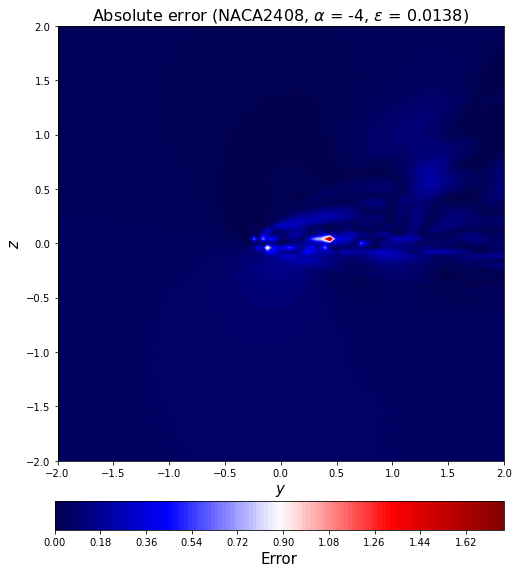

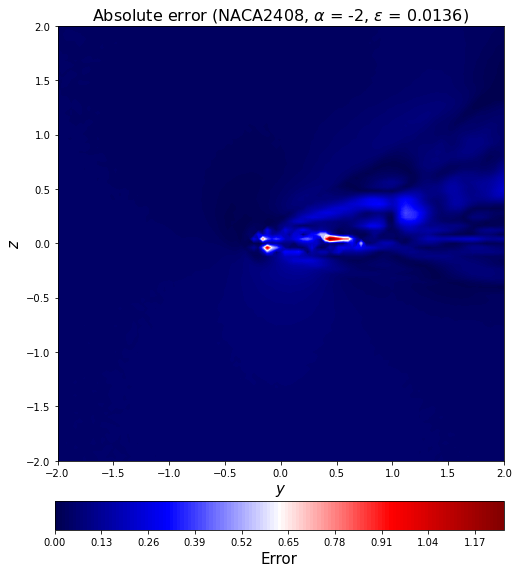

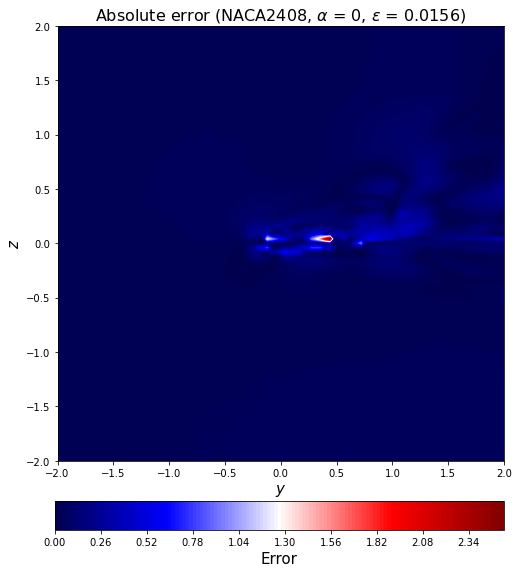

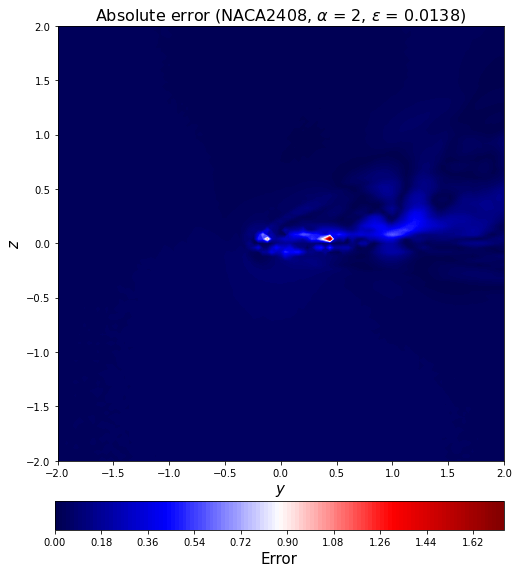

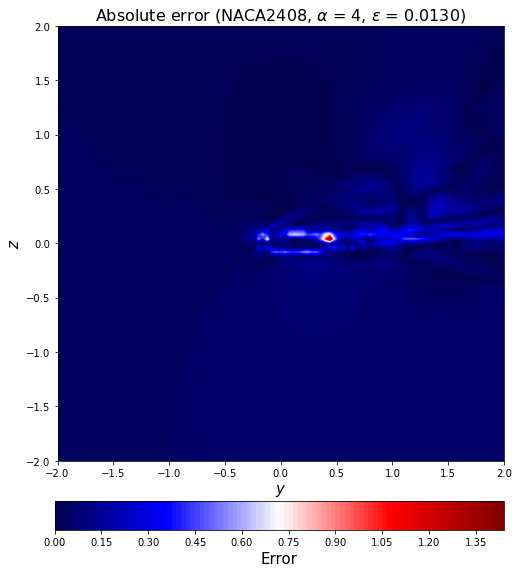

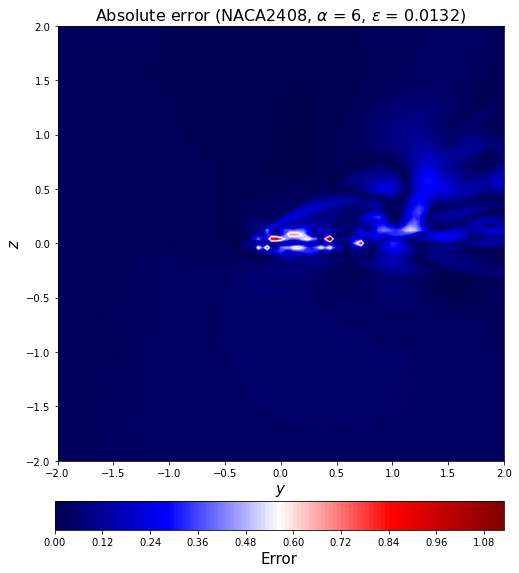

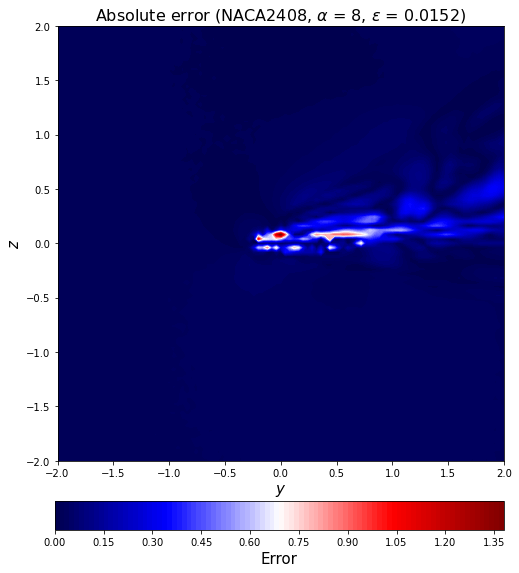

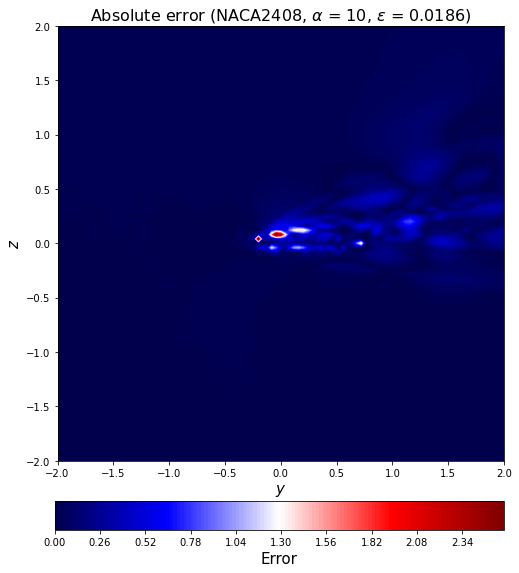

In [61]:
for c in range(0,11):
    error_train_abs2_rotate = error_train_abs[11*20+c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[11*20+c])[3:-2],
                                                                             aa_train[11*20+c], l2_error_train_list[11*20+c]),fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    save_fig_name = "20221019PredictionError_AeroCNN-II(-10to10)(training)"+str(np.array2string(geo_train[11*20+c])[3:-2])+str(aa_train[11*20+c])+".jpg"
    plt.savefig(save_fig_name, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [83]:
MAPE_train = (np.sum(np.abs(np.sum(y_train)-np.sum(decoded_train))) / np.abs(np.sum(y_train)))/(y_train.shape[0]/11)*100
acc_train = 1-MAPE_train

In [84]:
print(MAPE_train)
print(acc_train)

0.0058823040649004866
0.9941176959350995


In [85]:
MAPE_test = (np.sum(np.abs(np.sum(y_test)-np.sum(decoded_test))) / np.abs(np.sum(y_test)))/(y_test.shape[0]/11)*100
acc_test = 1-MAPE_test

In [86]:
print(MAPE_test)
print(acc_test)

0.10750218788312009
0.89249781211688


In [87]:
MAPE_train_list = []
acc_train_list = []
for i in range(0, len(aa_train)):
    MAPE_train_data = (np.sum(np.abs(y_train[i]-decoded_train[i])) / np.sum(np.abs(y_train[i])))/(y_train.shape[0]/11)*100
    MAPE_train_list.append(MAPE_train_data)
    acc_train_data = 1 - MAPE_train_data
    acc_train_list.append(acc_train_data)
print(MAPE_train_list)
print(acc_train_list)

[0.00803363628047757, 0.007889195887952621, 0.007653962706617376, 0.008062299526074805, 0.0075699045113633515, 0.0067205947070792926, 0.006664034911240728, 0.007368442206479527, 0.007205470948799329, 0.006868245207730023, 0.011313295803857955, 0.00981554462802263, 0.007457583981767723, 0.007626250404356858, 0.006958721783880945, 0.006802894190710087, 0.0063481395007828605, 0.006006340814011227, 0.006314610386702716, 0.005942316012180816, 0.00627006131880017, 0.010160702596424527, 0.008315011638678625, 0.009604175251057502, 0.008264533171844475, 0.008204821399871932, 0.007822454238088574, 0.006414546723315858, 0.006526777564233251, 0.007390538628712611, 0.006197446676999136, 0.0069479307517558, 0.007012099681649605, 0.007424968813320637, 0.007712491472214288, 0.008095144489684415, 0.0077953119415564666, 0.0077892625108306746, 0.006624480274308203, 0.006393970856973622, 0.006923853862610989, 0.007429066499375135, 0.006567773888853636, 0.007480305122611765, 0.019766117744765936, 0.0074579

In [88]:
MAPE_test_list = []
acc_test_list = []
for i in range(0, len(aa_test)):
    MAPE_test_data = (np.sum(np.abs(y_test[i]-decoded_test[i])) / np.sum(np.abs(y_test[i])))/(y_test.shape[0]/11)*100
    MAPE_test_list.append(MAPE_test_data)
    acc_test_data = 1 - MAPE_test_data
    acc_test_list.append(acc_test_data)
print(MAPE_test_list)
print(acc_test_list)

[0.12960538178875142, 0.13110861680042385, 0.13742563487783555, 0.13699876707757325, 0.1359971433356826, 0.11256751122698326, 0.1021049776811245, 0.1214612507876736, 0.11419009022950666, 0.11945237163440275, 0.19162285769882872, 0.15577191783857577, 0.14779795091737893, 0.1589775848357769, 0.15195823049687682, 0.17581532360242416, 0.16159840188354702, 0.14946328358646402, 0.1467321408325023, 0.1449251246496579, 0.140820557360032, 0.12104627970724563, 0.12298574843380083, 0.13573853271098707, 0.12902528065076355, 0.13348656169352313, 0.13399828258821112, 0.11973022647071964, 0.13336953334129056, 0.12826339037378778, 0.12419131790427934, 0.11964827711999204, 0.29935063415905017, 0.1623435417890995, 0.14727484825289092, 0.1264132871350428, 0.138122503838266, 0.12344526300547697, 0.12046953089847967, 0.12050277205655706, 0.12378199890450473, 0.1109670719430074, 0.13654680161853563, 0.14733851659716865, 0.1770473870277257, 0.151562908521584, 0.16117895043740116, 0.16098061806176725, 0.17142

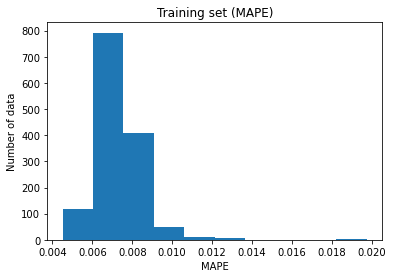

In [89]:
plt.hist(MAPE_train_list)
plt.title('Training set (MAPE)')
plt.ylabel('Number of data')
plt.xlabel('MAPE')
plt.show()

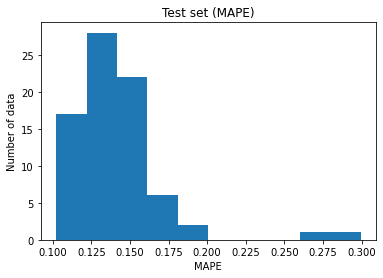

In [90]:
plt.hist(MAPE_test_list)
plt.title('Test set (MAPE)')
plt.ylabel('Number of data')
plt.xlabel('MAPE')
plt.show()

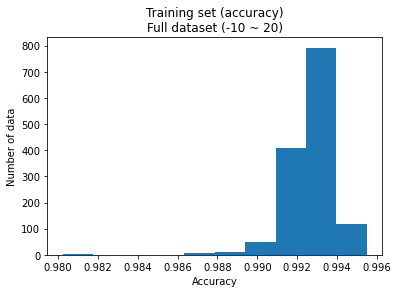

In [93]:
plt.hist(acc_train_list)
plt.title('Training set (accuracy)\nFull dataset (-10 ~ 20)')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
plt.show()

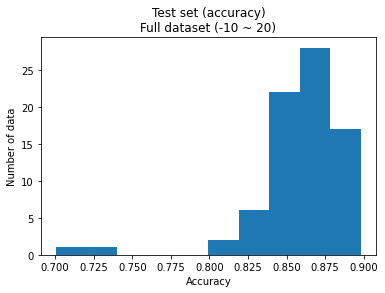

In [94]:
plt.hist(acc_test_list)
plt.title('Test set (accuracy)\nFull dataset (-10 ~ 20)')
plt.ylabel('Number of data')
plt.xlabel('Accuracy')
plt.show()